In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import time
import torchvision.models as models
from torchvision import datasets, transforms
import copy
import math
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
from models import *
from datetime import datetime
from pyhessian import hessian
import torchvision.transforms as tt
from tqdm import tqdm
import gensim.downloader as api
import torchtext
from torchtext.datasets import IMDB
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer
import string

import argparse
from config import Config

d:\Programs\Python\lib\site-packages\torchtext\datasets\__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
d:\Programs\Python\lib\site-packages\torchtext\data\__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
d:\Programs\Python\lib\site-packages\torchtext\vocab\__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is depreca

In [2]:
def flat_params(m):
    flat_data = []
    for p in m.parameters():
        flat_data.append(p.data.view(-1))
    return torch.cat(flat_data)

def grad_norm(model):
    total_norm = 0
    for p in model.parameters():
        param_norm = p.grad.detach().data.norm(2)
        total_norm += param_norm.item() ** 2
    return total_norm.cpu() ** 0.5

def zero_gradients(x):
    if x.grad is not None:
    	x.grad.zero_()

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def compute_jacobian(inputs, output):
	"""
	:param inputs: Batch X Size (e.g. Depth X Width X Height)
	:param output: Batch X Classes
	:return: jacobian: Batch X Classes X Size
	"""
	assert inputs.requires_grad

	num_classes = output.size()[1]

	jacobian = torch.zeros(num_classes, *inputs.size())
	grad_output = torch.zeros(*output.size())
	if inputs.is_cuda:
		grad_output = grad_output.cuda()
		jacobian = jacobian.cuda()

	for i in range(num_classes):
		zero_gradients(inputs)
		grad_output.zero_()
		grad_output[:, i] = 1
		output.backward(grad_output, retain_variables=True)
		jacobian[i] = inputs.grad.data

	return torch.transpose(jacobian, dim0=0, dim1=1)   

In [3]:
# class CoNLLDataset(Dataset):
#     def __init__(self, data_file, tokenizer, max_length=128):
#         self.sentences, self.labels = self.load_data(data_file)
#         self.tokenizer = tokenizer
#         self.max_length = max_length

#     def load_data(self, data_file):
#         # Load sentences and corresponding labels from the data file
#         sentences = []
#         labels = []
#         with open(data_file, 'r', encoding='utf-8') as f:
#             sentence = []
#             label = []
#             for line in f:
#                 line = line.strip()
#                 if line.startswith('-DOCSTART-') or line == '':
#                     if sentence:
#                         sentences.append(sentence)
#                         labels.append(label)
#                         sentence = []
#                         label = []
#                 else:
#                     word, _, _, ner_tag = line.split(' ')
#                     sentence.append(word)
#                     label.append(ner_tag)
#             if sentence:
#                 sentences.append(sentence)
#                 labels.append(label)
#         return sentences, labels

#     def encode_text(self, text):
#         inputs = self.tokenizer.encode_plus(text, add_special_tokens=True, truncation=True, max_length=self.max_length, padding='max_length')
#         input_ids = inputs['input_ids']
#         attention_mask = inputs['attention_mask']
#         return input_ids, attention_mask

#     def __len__(self):
#         return len(self.sentences)

#     def __getitem__(self, idx):
#         sentence = self.sentences[idx]
#         label = self.labels[idx]
#         input_ids, attention_mask = self.encode_text(sentence)
#         label_ids = [self.tokenizer.encode(label_i, add_special_tokens=False) for label_i in label]
#         return {
#             'input_ids': torch.tensor(input_ids),
#             'attention_mask': torch.tensor(attention_mask),
#             'label_ids': torch.tensor(label_ids)
#         }

In [4]:
def read_conll_file(file_path):
    """
    Read the data from a CoNLL-2003 format file.
    Args:
        file_path (str): Path to the CoNLL-2003 format file.
    Returns:
        List of tuples where each tuple contains a word and its corresponding label.
    """
    data = []
    with open(file_path, 'r', encoding='utf-8') as file:
        sentence = []
        for line in file:
            line = line.strip()
            if len(line) == 0:
                if len(sentence) > 0:
                    data.append(sentence)
                    sentence = []
            else:
                parts = line.split()
                word = parts[0]
                label = parts[-1]
                sentence.append((word, label))
        if len(sentence) > 0:
            data.append(sentence)
    return data

def convert_conll_data(data):
    """
    Convert CoNLL-2003 data into the required format.
    Args:
        data (list): List of tuples where each tuple contains a word and its corresponding label.
    Returns:
        List of tuples where each tuple contains a word and its label for each sentence.
    """
    converted_data = []
    for sentence in data:
        words, labels = zip(*sentence)
        converted_data.append((list(words), list(labels)))
    return converted_data

# Example usage:
# file_path = "./data/conll2003/train.txt"
# conll_data = read_conll_file(file_path)
# formatted_data = convert_conll_data(conll_data)
# print(formatted_data[:10])


In [5]:
# train_data = convert_conll_data(read_conll_file(file_path))
# word2vec_model = api.load("glove-twitter-25")
# word_matrix = torch.tensor(word2vec_model.vectors)
# word_to_index = {word: index for index, word in enumerate(word2vec_model.index_to_key)}

# # Define a function to tokenize, preprocess, and pad text using GloVe embeddings
# def tokenize_and_pad(text, word_to_index, max_length):
#     # Convert tokens to indices using pre-processed word_to_index mapping
#     token_indices = [word_to_index[token.lower()] if token.lower() in word_to_index else 0 for token in text]
#     # Pad token indices to max_length
#     padded_indices = token_indices + [0] * (max_length - len(token_indices))
#     return padded_indices


# # Define a custom dataset class
# class CoNLLDataset(Dataset):
#     def __init__(self, data, glove_model, max_length):
#         self.data = data
#         self.glove_model = glove_model
#         self.max_length = max_length

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, idx):
#         words, target = self.data[idx]
#         token_indices = tokenize_and_pad(words, word_to_index, self.max_length)
#         tags = {'O': 0, 'B-PER': 1, 'I-PER': 2, 'B-ORG': 3, 'I-ORG': 4, 'B-LOC': 5, 'I-LOC': 6, 'B-MISC': 7, 'I-MISC': 8}
#         target = [tags[tag] for tag in target] + [0] * (self.max_length - len(target))
#         return torch.tensor(token_indices, dtype=torch.long),  torch.tensor(target, dtype=torch.long)



# # Create DataLoader for training and validation sets
# train_dataset = CoNLLDataset(train_data, word2vec_model, 128)
# valid_dataset = CoNLLDataset(train_data, word2vec_model, 128)

# train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

# for i, j in train_loader:
#     print(i, " : ", j)
#     break

In [40]:
def train_net(device, settings):


    ########### Setup Data and Model ###########    
    if settings["dataset"]=="MNIST":

        #data
        train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transforms.ToTensor())
        validation_dataset = datasets.MNIST('./data', train=False, download=True, transform=transforms.ToTensor())
        train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=settings["bs"], shuffle=True, num_workers=8, pin_memory=True, persistent_workers=True)
        validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=settings["bs"], shuffle=False, num_workers=8, pin_memory=True, persistent_workers=True)
        
        
        subset = random.sample(range(train_dataset.data.shape[0]),int(settings["subset"]))
        sample_ds_hess = torch.utils.data.Subset(train_dataset, subset)
        sample_sampler_hess = torch.utils.data.RandomSampler(sample_ds_hess)
        hess_loader = torch.utils.data.DataLoader(sample_ds_hess, sampler=sample_sampler_hess, batch_size=settings["bs"], num_workers=8, pin_memory=True, persistent_workers=True)

        
        #model
        if settings["net"] == "MLP1": 
            model = MNISTNet1().to(device)
        elif settings["net"] == "MLP2":
            model = MNISTNet2().to(device)
        elif settings["net"] == "MLP3":
            model = MNISTNet3().to(device)
        else: print("model not defined")
        criterion = nn.CrossEntropyLoss()

    elif settings["dataset"]=="FMNIST":

        #data
        train_dataset = datasets.FashionMNIST('./data',download=True, train= True, transform=transforms.ToTensor())
        validation_dataset = datasets.FashionMNIST('./data',download=True, train= False, transform=transforms.ToTensor())
        

        #testloader
        train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=settings["bs"], shuffle=True, num_workers=8, pin_memory=True, persistent_workers=True)
        validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=settings["bs"], shuffle=False, num_workers=8, pin_memory=True, persistent_workers=True)       

        #hessloader subset
        subset = random.sample(range(train_dataset.data.shape[0]),int(settings["subset"]))
        sample_ds_hess = torch.utils.data.Subset(train_dataset, subset)
        sample_sampler_hess = torch.utils.data.RandomSampler(sample_ds_hess)
        hess_loader = torch.utils.data.DataLoader(sample_ds_hess, sampler=sample_sampler_hess, batch_size=settings["bs"], num_workers=8, pin_memory=True, persistent_workers=True)


        #models
        if settings["net"] == "MLP1": 
            model = MNISTNet1().to(device)
        elif settings["net"] == "MLP2":
            model = MNISTNet2().to(device)
        elif settings["net"] == "MLP3":
            model = MNISTNet3().to(device)
        else: print("model not defined")
        criterion = nn.CrossEntropyLoss()

    elif settings["dataset"]=="CIFAR":

        #data transforms
        transform_train = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ])

        transform_test = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ])


        #data
        train_dataset = torchvision.datasets.CIFAR10(root='./data', download=True, train=True, transform=transform_train)
        validation_dataset = torchvision.datasets.CIFAR10(root='./data', download=True, train=False, transform=transform_test)
        
        #trainloader subset
        train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=settings["bs"], shuffle=True, num_workers=2, pin_memory=True, persistent_workers=True)
        #subset = random.sample(range(train_dataset.data.shape[0]),settings["subset"])
        #sample_ds = torch.utils.data.Subset(train_dataset, subset)
        #sample_sampler = torch.utils.data.RandomSampler(sample_ds)
        #train_loader = torch.utils.data.DataLoader(sample_ds, sampler=sample_sampler, batch_size=settings["bs"], num_workers=8, pin_memory=True, persistent_workers=True)

        #hessloader subset
        subset = random.sample(range(train_dataset.data.shape[0]),int(settings["subset"]))
        sample_ds_hess = torch.utils.data.Subset(train_dataset, subset)
        sample_sampler_hess = torch.utils.data.RandomSampler(sample_ds_hess)
        hess_loader = torch.utils.data.DataLoader(sample_ds_hess, sampler=sample_sampler_hess, batch_size=settings["bs"], num_workers=8, pin_memory=True, persistent_workers=True)

        #testloader
        validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=settings["bs"], shuffle=False, num_workers=8, pin_memory=True, persistent_workers=True)       

        #models
        if settings["net"] == "CNN1": 
            model = CIFARCNN1().to(device)
        elif settings["net"] == "CNN2": 
            model = CIFARCNN2().to(device)
        elif settings["net"] == "CNN3": 
            model = CIFARCNN3().to(device)
        elif settings["net"] == "CIFAR10Res18":
            model = ResNet18().to(device)
        elif settings["net"] == "CIFAR10Res34":
            model = ResNet34().to(device)

        else: print("model not defined")
        criterion = nn.CrossEntropyLoss() 

    elif settings["dataset"]=="CIFAR100":
        stats = ((0.5074,0.4867,0.4411),(0.2011,0.1987,0.2025))
        train_transform = tt.Compose([tt.RandomHorizontalFlip(),tt.RandomCrop(32,padding=4,padding_mode="reflect"),tt.ToTensor(), tt.Normalize(*stats)])
        test_transform = tt.Compose([tt.ToTensor(),tt.Normalize(*stats)])
        train_dataset = datasets.CIFAR100(download=True,root="./data",transform=train_transform)
        test_data = datasets.CIFAR100(root="./data",train=False,transform=test_transform)

        #trainloader subset
        train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=settings["bs"],num_workers=8,pin_memory=True,shuffle=True, persistent_workers=True)
       
        #hessloader
        subset = random.sample(range(train_dataset.data.shape[0]),int(settings["subset"]))
        sample_ds_hess = torch.utils.data.Subset(train_dataset, subset)
        sample_sampler_hess = torch.utils.data.RandomSampler(sample_ds_hess)    
        hess_loader = torch.utils.data.DataLoader(sample_ds_hess, sampler=sample_sampler_hess, batch_size=settings["bs"], num_workers=8, pin_memory=True, persistent_workers=True)
    
        #testloader       
        validation_loader = torch.utils.data.DataLoader(test_data,batch_size=settings["bs"],num_workers=8,pin_memory=True, persistent_workers=True)

        #models
        if settings["net"] == "CIFAR100vgg": 
            model = vgg11_bn().to(device)
        else: print("model not defined")
        criterion = nn.CrossEntropyLoss() 

    elif settings["dataset"] == "imdb":
        df = pd.read_csv(".//data//imdb_train_sup.csv")
        # Convert review to binary (1 for positive, 0 for negative)
        df['Label'] = df['Label'].apply(lambda x: 1 if x > 5 else 0)

        # Split into training and validation sets
        train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
        word2vec_model = api.load("glove-twitter-25")
        word_matrix = torch.tensor(word2vec_model.vectors)
        word_to_index = {word: index for index, word in enumerate(word2vec_model.index_to_key)}

        # Define a function to tokenize, preprocess, and pad text using GloVe embeddings
        def tokenize_and_pad(text, word_to_index, max_length):
            # Define set of punctuation characters to be removed
            punctuations = set(string.punctuation)
            # Tokenize text, preprocess (remove punctuations), and limit to max_length
            tokens = [token.lower() for token in text.split() if token.lower() not in punctuations][:max_length]
            # Convert tokens to indices using pre-processed word_to_index mapping
            token_indices = [word_to_index[token] if token in word_to_index else 0 for token in tokens]
            # Pad token indices to max_length
            padded_indices = token_indices + [0] * (max_length - len(token_indices))
            return padded_indices


        # Define a custom dataset class
        class CustomDataset(Dataset):
            def __init__(self, reviews, targets, glove_model, max_length):
                self.reviews = reviews
                self.targets = targets
                self.glove_model = glove_model
                self.max_length = max_length

            def __len__(self):
                return len(self.reviews)

            def __getitem__(self, idx):
                review = str(self.reviews.iloc[idx])
                target = self.targets.iloc[idx]
                token_indices = tokenize_and_pad(review, word_to_index, self.max_length)
                return torch.tensor(token_indices, dtype=torch.long),  torch.tensor(target)
        
        

        # Create DataLoader for training and validation sets
        train_dataset = CustomDataset(train_df["Review"], train_df["Label"], word2vec_model, 128)
        valid_dataset = CustomDataset(val_df["Review"], val_df["Label"], word2vec_model, 128)

        train_loader = DataLoader(train_dataset, batch_size=settings["bs"], shuffle=True)
        # subset = random.sample(range(train_dataset.data.shape[0]),int(settings["subset"]))
        # sample_ds_hess = torch.utils.data.Subset(train_dataset, subset)
        # sample_sampler_hess = torch.utils.data.RandomSampler(sample_ds_hess)    
        # hess_loader = torch.utils.data.DataLoader(sample_ds_hess, sampler=sample_sampler_hess, batch_size=settings["bs"], num_workers=8, pin_memory=True, persistent_workers=True)
    
        #testloader       
        validation_loader = DataLoader(valid_dataset,batch_size=settings["bs"])
        
        
        # Model selection
        if settings["net"] == "trans1": 
            model = ImdbNet1(word_matrix, emb_dim=25, num_heads=5, hidden_dim=64, num_layers=3, num_classes=2, device=device).to(device)
        if settings["net"] == "trans2": 
            model = ImdbNet1(word_matrix, emb_dim=25, num_heads=5, hidden_dim=64, num_layers=1, num_classes=2, device=device).to(device)
        if settings["net"] == "trans3": 
            model = ImdbNet1(word_matrix, emb_dim=25, num_heads=5, hidden_dim=128, num_layers=6, num_classes=2, device=device).to(device)
        else: 
            print("model not defined")

        # Loss function
        criterion = nn.CrossEntropyLoss()

    elif settings["dataset"] =="conll2003":
        #data
        file_path = "./data/conll2003/train.txt"
        train_data = convert_conll_data(read_conll_file(file_path))
        max_sent_len = 128
        word2vec_model = api.load("glove-twitter-25")
        word_matrix = torch.tensor(word2vec_model.vectors)
        word_to_index = {word: index for index, word in enumerate(word2vec_model.index_to_key)}

        # Define a function to tokenize, preprocess, and pad text using GloVe embeddings
        def tokenize_and_pad(text, word_to_index, max_length):
            # Convert tokens to indices using pre-processed word_to_index mapping
            token_indices = [word_to_index[token.lower()] if token.lower() in word_to_index else 0 for token in text]
            # Pad token indices to max_length
            padded_indices = token_indices + [0] * (max_length - len(token_indices))
            return padded_indices


        # Define a custom dataset class
        class CoNLLDataset(Dataset):
            def __init__(self, data, glove_model, max_length):
                self.data = data
                self.glove_model = glove_model
                self.max_length = max_length

            def __len__(self):
                return len(self.data)

            def __getitem__(self, idx):
                words, target = self.data[idx]
                token_indices = tokenize_and_pad(words, word_to_index, self.max_length)
                tags = {'O': 0, 'B-PER': 1, 'I-PER': 2, 'B-ORG': 3, 'I-ORG': 4, 'B-LOC': 5, 'I-LOC': 6, 'B-MISC': 7, 'I-MISC': 8}
                target = [tags[tag] for tag in target] + [0] * (self.max_length - len(target))
                return torch.tensor(token_indices, dtype=torch.long),  torch.tensor(target, dtype=torch.long)



        # Create DataLoader for training and validation sets
        train_dataset = CoNLLDataset(train_data, word2vec_model, max_sent_len)
        valid_dataset = CoNLLDataset(train_data, word2vec_model, max_sent_len)
        train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=settings["bs"], shuffle=True )
        validation_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=settings["bs"], shuffle=False)
        
        
        # subset = random.sample(range(train_dataset.data.shape[0]),int(settings["subset"]))
        # sample_ds_hess = torch.utils.data.Subset(train_dataset, subset)
        # sample_sampler_hess = torch.utils.data.RandomSampler(sample_ds_hess)
        # hess_loader = torch.utils.data.DataLoader(sample_ds_hess, sampler=sample_sampler_hess, batch_size=settings["bs"], num_workers=8, pin_memory=True, persistent_workers=True)

        
        #model
        if settings["net"] == "NER1": 
            # model = NNCRF(conf).to(device)
            model = BiLSTMNER(word_matrix, 25, 50, 4, 9, device).to(device)
        else: 
            print("Invalid Model")
        criterion = nn.CrossEntropyLoss()

    elif settings["dataset"]=="Electric_Production":

        data = pd.read_csv('data/Electric_Production.csv',index_col='DATE',parse_dates=True)
        # data = data.drop([565,566,1290])

        # data['Daily minimum temperatures'] = data['Daily minimum temperatures'].astype('float32')
        winSize = 12
        nFeatures = 1
        train = data.copy()
        scaler = MinMaxScaler()
        trainScaled = scaler.fit_transform(train)
        def slidingWindow( data, winSize):
            Xtrain = []
            ytrain = []
            for i in range( winSize, len(data) ):
                # Here i points to end of Window at each iteration, So minus it by winSize to go to start of window
                Xtrain.append( data[i-winSize:i] ) #Note, this will select all elements as X except last element i because of slicing
                ytrain.append( data[i] ) # Make ith(end of window) element as Y instance values
            return np.array(Xtrain), np.array(ytrain) # Convert them to np arrays since torch uses that
        X , y = slidingWindow(trainScaled , winSize)

        trainSize = len(train) - winSize*3
        testSize = len(train) - trainSize
        print("Train size = ", trainSize)
        Xtrain = torch.tensor( np.array( X[:trainSize] ) )
        ytrain = torch.tensor( np.array( y[:trainSize] ) )

        Xtest = torch.tensor( np.array( X[testSize:] ) )
        ytest = torch.tensor( np.array( y[testSize:] ) )

        train_dataset = TensorDataset(Xtrain, ytrain)
        test_dataset = TensorDataset(Xtest, ytest)


        # Create dataloaders for training and validation
        train_loader = DataLoader(train_dataset,batch_size=settings["bs"], shuffle=True, num_workers=4, pin_memory=True, persistent_workers=True)
        validation_loader = DataLoader(test_dataset, batch_size=settings["bs"], shuffle=False, num_workers=4, pin_memory=True, persistent_workers=True)

        subset = random.sample(range(train_dataset._len_()),int(settings["subset"]/100))
        sample_ds_hess = torch.utils.data.Subset(train_dataset, subset)
        sample_sampler_hess = torch.utils.data.RandomSampler(sample_ds_hess)
        hess_loader = torch.utils.data.DataLoader(sample_ds_hess, sampler=sample_sampler_hess, batch_size=settings["bs"], num_workers=4, pin_memory=True, persistent_workers=True)
        # epochs = 2000
        # lr = 0.002

        inputSize = nFeatures # inp embedding size i.e, no of features in the X
        hiddenSize = 100      # Hidden layer neurons
        nLayers = 1           # no of layers

        if settings["net"] == "LSTM": 
            model = LSTM(inputSize, hiddenSize, nLayers).to(device)

        criterion = torch.nn.MSELoss()
    
    elif settings["dataset"]=="min_temp":

        data = pd.read_csv('data\daily-minimum-temperatures-in-me.csv',index_col='Date',parse_dates=True)
        print(data)
        data = data.drop(['7/20/1982','7/21/1982','7/14/1984'])
        
        data['Daily minimum temperatures'] = data['Daily minimum temperatures'].astype('float32')
        winSize = 12
        nFeatures = 1
        train = data.copy()
        scaler = MinMaxScaler()
        trainScaled = scaler.fit_transform(train)
        def slidingWindow( data, winSize):
            Xtrain = []
            ytrain = []
            for i in range( winSize, len(data) ):
                # Here i points to end of Window at each iteration, So minus it by winSize to go to start of window
                Xtrain.append( data[i-winSize:i] ) #Note, this will select all elements as X except last element i because of slicing
                ytrain.append( data[i] ) # Make ith(end of window) element as Y instance values
            return np.array(Xtrain), np.array(ytrain) # Convert them to np arrays since torch uses that
        X , y = slidingWindow(trainScaled , winSize)

        trainSize = len(train) - winSize*3
        testSize = len(train) - trainSize
        print("Train size = ", trainSize)
        Xtrain = torch.tensor( np.array( X[:trainSize] ) )
        ytrain = torch.tensor( np.array( y[:trainSize] ) )

        Xtest = torch.tensor( np.array( X[testSize:] ) )
        ytest = torch.tensor( np.array( y[testSize:] ) )

        train_dataset = TensorDataset(Xtrain, ytrain)
        test_dataset = TensorDataset(Xtest, ytest)


        # Create dataloaders for training and validation
        train_loader = DataLoader(train_dataset,batch_size=settings["bs"], shuffle=True, num_workers=4, pin_memory=True, persistent_workers=True)
        validation_loader = DataLoader(test_dataset, batch_size=settings["bs"], shuffle=False, num_workers=4, pin_memory=True, persistent_workers=True)

        # subset = random.sample(range(train_dataset.len()),int(settings["subset"]/100))
        # sample_ds_hess = torch.utils.data.Subset(train_dataset, subset)
        # sample_sampler_hess = torch.utils.data.RandomSampler(sample_ds_hess)
        # hess_loader = torch.utils.data.DataLoader(sample_ds_hess, sampler=sample_sampler_hess, batch_size=settings["bs"], num_workers=4, pin_memory=True, persistent_workers=True)
        # epochs = 2000
        # lr = 0.002

        inputSize = nFeatures # inp embedding size i.e, no of features in the X
        hiddenSize = 100      # Hidden layer neurons
        nLayers = 1           # no of layers

        if settings["net"] == "LSTM": 
            model = LSTM(inputSize, hiddenSize, nLayers).to(device)

        criterion = torch.nn.MSELoss()

        
    else:
        print("Invalid Error. Dataset not found")

    ########### Setup Optimizer ###########   
    if settings["optimizer"]=="SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=settings["lr"],momentum=0.9, weight_decay=5e-4)
    elif settings["optimizer"]=="Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=settings["lr"])        
    else: print("method not defined!!")

    if settings["scheduler"]:
        #scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50, 100], gamma=0.1)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, int(settings["epochs"]))
        
    sigma_curr = settings["sigma"]

    ########### Setup Writer Variables ###########  
    results = {"rec_steps":[], "train_loss":[], "test_loss":[],"hess":[], "test_acc":[], "train_acc":[], "hess_trace":[], "l1_norm":[], "l2_norm":[], "grad_norm":[]}    

    ########### Getting number of layers ###########      
    n_groups = 0
    dim_model = 0
    with torch.no_grad():
        for param in model.parameters():   
            n_groups = n_groups + 1
            dim_model = dim_model + torch.numel(param)
    print('Model dimension: ' + str(dim_model))
    print('Number of groups: ' + str(n_groups))

    ##### iteration counter
    iter = 0
    
	########### Training ###########     
    for epoch in range(settings["epochs"]):
        start_time = time.time()
        # print('epoch #'+str(epoch)+', lr = '+str(get_lr(optimizer)))

        ########### Computing Hessian if last iteration #####
        hess_train = 0
        if settings["hess_record"]:
            if epoch%(settings["epochs"]//10)==1:
                model.eval()
                optimizer.zero_grad(set_to_none=True)
                for d in hess_loader:
                    data, target = d[0].to(device, non_blocking=True),d[1].to(device, non_blocking=True)
                    hess_train = hess_train+np.sum(hessian(model, criterion, data=(data, target), cuda=True).trace())/len(hess_loader) 
                optimizer.zero_grad(set_to_none=True)

        ########### Saving stats every few epochs ########### 
        if (epoch%settings["rec_step"])==0:
            results["rec_steps"].append(epoch)
            model.eval()
            
            #computing stats: train loss
            train_loss, correct = 0, 0
            for d in train_loader:
                data, target = d[0].to(device, non_blocking=True),d[1].to(device, non_blocking=True)
                output = model(data)
                train_loss += criterion(output, target).data.item()/len(train_loader)
                pred = output.data.max(1)[1] # get the index of the max log-probability
                correct += pred.eq(target.data).cpu().sum()
            accuracy_train = 100. * correct.to(torch.float32) / len(train_loader.dataset)
            if settings["dataset"] =="conll2003":
                accuracy_train/=max_sent_len

            #computing stats: test loss
            test_loss, correct = 0, 0
            for data, target in validation_loader:
                data = data.to(device, non_blocking=True)
                target = target.to(device, non_blocking=True)
                output = model(data)
                #d_out = output.size[-1]
                #print(d_out)
                test_loss += criterion(output, target).data.item()/len(validation_loader)
                pred = output.data.max(1)[1] # get the index of the max log-probability
                correct += pred.eq(target.data).cpu().sum()
            accuracy_test = 100. * correct.to(torch.float32) / len(validation_loader.dataset)
            if settings["dataset"] =="conll2003":
                accuracy_test/= max_sent_len

            #regularized loss
            # J = torch.zeros((d_out, dim_model))
            # for data, target in validation_loader:
            #     data = data.to(device, non_blocking=True)
            #     target = target.to(device, non_blocking=True)
            #     output = model(data)
            #     J = J + torch.mean(compute_jacobian(data, output),0) / len(train_loader)            

            #saving stats
            results["train_loss"].append(train_loss)
            results["train_acc"].append(accuracy_train)
            results["test_loss"].append(test_loss)
            results["test_acc"].append(accuracy_test)
            if epoch%(settings["epochs"]//10)==1:
                results["hess"].append(hess_train)
            results["l1_norm"].append(torch.norm(flat_params(model),1).cpu().detach().numpy())
            results["l2_norm"].append(torch.norm(flat_params(model),2).cpu().detach().numpy())
            #results["grad_norm"].append(grad_norm(model).numpy())

            print('Epoch {}: Train L: {:.4f}, TrainAcc: {:.2f}, Test L: {:.4f}, TestAcc: {:.2f}, LearningRate: {:.5f} '.format(epoch, train_loss, accuracy_train, test_loss, accuracy_test, get_lr(optimizer)), end=" ")

        ########### Saving stats every few epochs ########### 
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            ### model perturbation
            if epoch<135:
                if settings["noise"] != "no":
                    param_copy = []
                    with torch.no_grad():
                        i=0
                        for param in model.parameters():
                            param_copy.append(param.data)
                            if settings["noise"] == "all" or settings["noise"] == "after_all":
                                param.data = param.data + (sigma_curr/math.sqrt(n_groups))*torch.normal(0, 1, size=param.size(),device=device)
                            elif settings["noise"] == "layer" or settings["noise"] == "after_layer":
                                if i==(iter%n_groups):
                                    param.data = param.data + sigma_curr*torch.normal(0, 1, size=param.size(),device=device)
                                i = i+1

            ### backprop
            data = data.to(device)
            target = target.to(device)
            optimizer.zero_grad() 
            output = model(data)
            loss = criterion(output, target)
            loss.backward()

            ### model recovery
            if settings["noise"] != "no" and settings["noise"] != "after_all" and settings["noise"] != "after_layer":
                with torch.no_grad():
                    i=0
                    for param in model.parameters():
                        param.data = param_copy[i]
                        i=i+1

            optimizer.step()
            #print(loss.item())
            iter = iter +1

        if settings["scheduler"]:
            scheduler.step()
        print("Time Taken: ", time.time()-start_time)

    return results

def settings_to_str(settings):
    return datetime.now().strftime("%H_%M_%S")+ '_' + settings["dataset"] + "_" + settings["net"] + "_noise_" + settings["noise"] + '_subset' + str(settings["subset"])  + '_bs' + str(settings["bs"]) + '_' + settings["optimizer"] + '_lr' + str(settings["lr"]) + '_sigma'+ str(settings["sigma"])+ '_rec'+ str(settings["rec_step"])


In [7]:
def plot_comparison(results_dict):
    num_metrics = len(next(iter(results_dict.values())))
    num_plots = num_metrics // 2 + num_metrics % 2  # Calculate the number of rows required for plotting

    fig, axes = plt.subplots(num_plots, 2, figsize=(12, 4 * num_plots))

    for i, metric in enumerate(list(results_dict.values())[0]):
        row = i // 2
        col = i % 2

        for label, results in results_dict.items():
            axes[row, col].plot([i for i in range(len(results[metric])//5, len(results[metric]))], results[metric][len(results[metric])//5:], label=label)

        axes[row, col].set_title(metric)
        axes[row, col].set_xlabel("Epoch")
        axes[row, col].set_ylabel(metric)
        axes[row, col].legend()

    plt.tight_layout()
    plt.show()

In [8]:
assert 1==2

AssertionError: 

# MNIST

## MNIST and MLP1

In [ ]:

# example comparing different noise injections to vanilla SGD

# GPU = [2,3]
# dataset = "CIFAR"
# subset = 50000
# nep = 50
# bs = 128
# rec_step = 1
# net = "CIFAR10Res18"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Print the device being used
print("Device in use:", device)

dataset = "MNIST"
subset = 200
no_of_ep = 50
batch_size = 128
rec_step = 1
net = "MLP1"
hess_record = True
save = True

print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -")
print("No Noise")
noise = "no" # no noise
sigma = 0.03
lr1 = 0.01
settings = {"dataset":dataset, "subset": subset, "net": net, "optimizer":"SGD", "scheduler":True, "noise":noise, "bs":batch_size, "lr":lr1, "sigma":sigma, "epochs":no_of_ep, "rec_step":rec_step, "hess_record": hess_record}
results_no = train_net(device, settings)
if(save):
    torch.save(results_no, 'results/'+settings_to_str(settings)+'.pt') 

print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -")
print("Layerwise Noise")
noise = "layer" #layer
sigma = 0.03
lr1 = 0.01
settings = {"dataset":dataset, "subset": subset, "net": net, "optimizer":"SGD", "scheduler":True, "noise":noise, "bs":batch_size, "lr":lr1, "sigma":sigma, "epochs":no_of_ep, "rec_step":rec_step, "hess_record": hess_record}
results_layer = train_net(device,settings)
if(save):
    torch.save(results_layer, 'results/'+settings_to_str(settings)+'.pt') 

print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -")
print("All Layer Noise")
noise = "all" # all
sigma = 0.03
lr1 = 0.01
settings = {"dataset":dataset, "subset": subset, "net": net, "optimizer":"SGD", "scheduler":True, "noise":noise, "bs":batch_size, "lr":lr1, "sigma":sigma, "epochs":no_of_ep, "rec_step":rec_step, "hess_record": hess_record}
results_all = train_net(device,settings)
if(save):
    torch.save(results_all, 'results/'+settings_to_str(settings)+'.pt') 

print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -")
print("After GD Noise All")
noise = "after_all" # after [noise injected after doing gradient descent]
sigma = 0.0003
lr1 = 0.01
settings = {"dataset":dataset, "subset": subset, "net": net, "optimizer":"SGD", "scheduler":True, "noise":noise, "bs":batch_size, "lr":lr1, "sigma":sigma, "epochs":no_of_ep, "rec_step":rec_step, "hess_record": hess_record}
results_after_all = train_net(device, settings)
if(save):
    torch.save(results_after_all, 'results/'+settings_to_str(settings)+'.pt') 

print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -")
print("After GD Noise Layer")
noise = "after_layer" # after [noise injected after doing gradient descent]
sigma = 0.0003
lr1 = 0.01
settings = {"dataset":dataset, "subset": subset, "net": net, "optimizer":"SGD", "scheduler":True, "noise":noise, "bs":batch_size, "lr":lr1, "sigma":sigma, "epochs":no_of_ep, "rec_step":rec_step, "hess_record": hess_record}
results_after_layer = train_net(device, settings)
if(save):
    torch.save(results_after_layer, 'results/'+settings_to_str(settings)+'.pt') 

Device in use: cuda
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
No Noise
Model dimension: 898510
Number of groups: 8
Epoch 0: Train L: 2.3031, TrainAcc: 10.71, Test L: 2.3028, TestAcc: 10.55, LearningRate: 0.01000  Time Taken:  21.035614252090454


d:\Programs\Python\lib\site-packages\torch\autograd\__init__.py:266: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at ..\torch\csrc\autograd\engine.cpp:1182.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1: Train L: 0.3208, TrainAcc: 90.70, Test L: 0.3118, TestAcc: 90.96, LearningRate: 0.00999  Time Taken:  58.9878306388855
Epoch 2: Train L: 0.1950, TrainAcc: 94.36, Test L: 0.1912, TestAcc: 94.12, LearningRate: 0.00996  Time Taken:  3.3039186000823975
Epoch 3: Train L: 0.1368, TrainAcc: 96.13, Test L: 0.1406, TestAcc: 95.78, LearningRate: 0.00991  Time Taken:  3.444425344467163
Epoch 4: Train L: 0.1010, TrainAcc: 97.11, Test L: 0.1122, TestAcc: 96.47, LearningRate: 0.00984  Time Taken:  3.5789873600006104
Epoch 5: Train L: 0.0781, TrainAcc: 97.80, Test L: 0.0912, TestAcc: 97.20, LearningRate: 0.00976  Time Taken:  3.50142502784729
Epoch 6: Train L: 0.0678, TrainAcc: 98.04, Test L: 0.0869, TestAcc: 97.32, LearningRate: 0.00965  Time Taken:  3.894458293914795
Epoch 7: Train L: 0.0556, TrainAcc: 98.43, Test L: 0.0811, TestAcc: 97.38, LearningRate: 0.00952  Time Taken:  3.502769708633423
Epoch 8: Train L: 0.0509, TrainAcc: 98.63, Test L: 0.0754, TestAcc: 97.50, LearningRate: 0.00938 

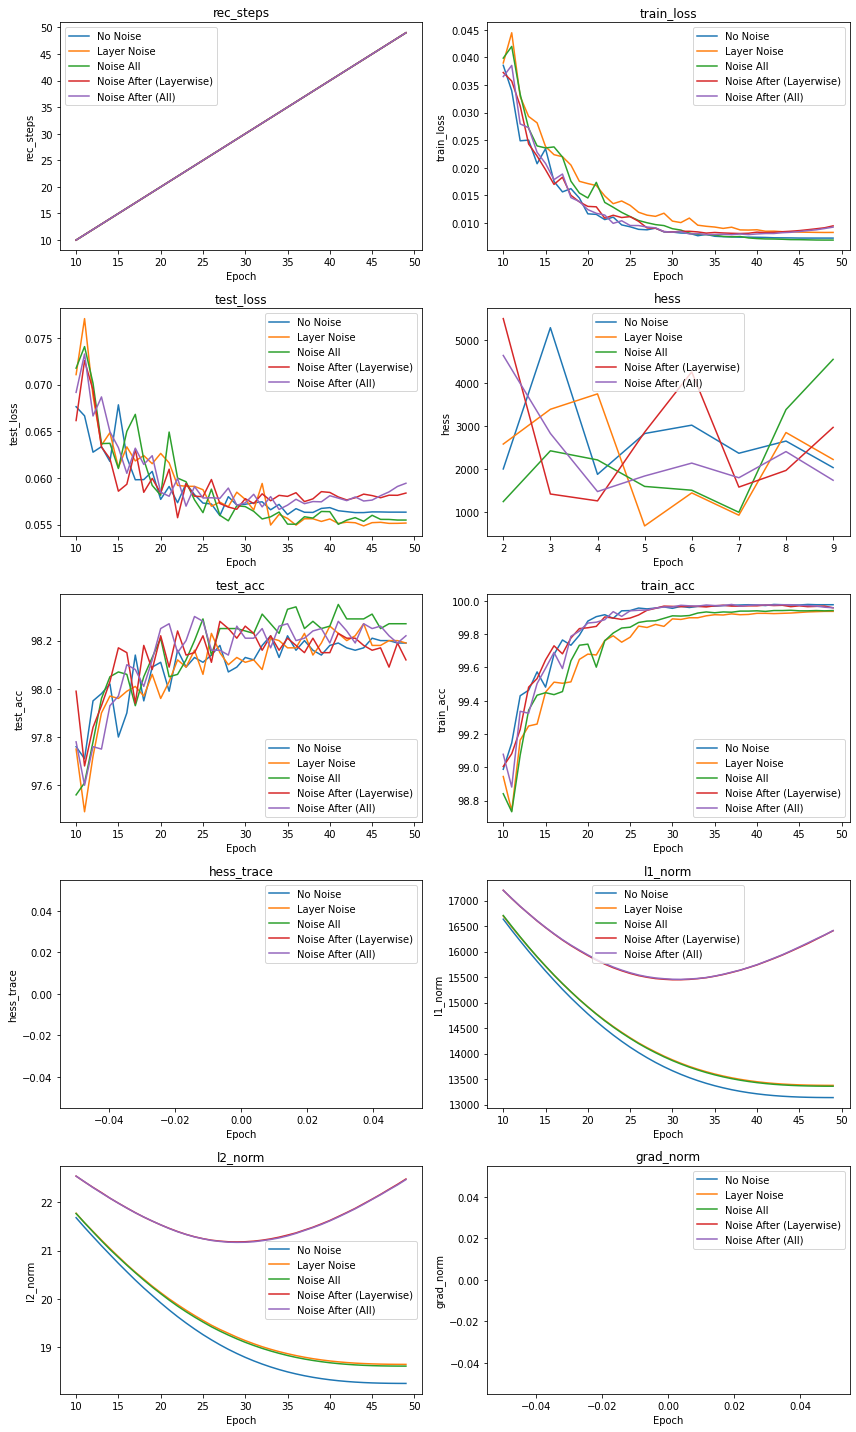

In [ ]:
# Assuming results_no and results_layer are dictionaries containing the respective metrics
results = {"No Noise": results_no, "Layer Noise": results_layer, "Noise All": results_all, "Noise After (Layerwise)": results_after_layer, "Noise After (All)": results_after_all}
plot_comparison(results)

In [ ]:
# assert 1==2

## MNIST and MLP2

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Print the device being used
print("Device in use:", device)

dataset = "MNIST"
subset = 5000
no_of_ep = 50
batch_size = 128
rec_step = 1
net = "MLP2"
hess_record = True
save = True

print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -")
print("No Noise")
noise = "no" # no noise
sigma = 0.03
lr1 = 0.01
settings = {"dataset":dataset, "subset": subset, "net": net, "optimizer":"SGD", "scheduler":True, "noise":noise, "bs":batch_size, "lr":lr1, "sigma":sigma, "epochs":no_of_ep, "rec_step":rec_step, "hess_record": hess_record}
results_no = train_net(device, settings)
if(save):
    torch.save(results_no, 'results/'+settings_to_str(settings)+'.pt') 

print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -")
print("Layerwise Noise")
noise = "layer" #layer
sigma = 0.03
lr1 = 0.01
settings = {"dataset":dataset, "subset": subset, "net": net, "optimizer":"SGD", "scheduler":True, "noise":noise, "bs":batch_size, "lr":lr1, "sigma":sigma, "epochs":no_of_ep, "rec_step":rec_step, "hess_record": hess_record}
results_layer = train_net(device,settings)
if(save):
    torch.save(results_layer, 'results/'+settings_to_str(settings)+'.pt') 

print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -")
print("All Layer Noise")
noise = "all" # all
sigma = 0.03
lr1 = 0.01
settings = {"dataset":dataset, "subset": subset, "net": net, "optimizer":"SGD", "scheduler":True, "noise":noise, "bs":batch_size, "lr":lr1, "sigma":sigma, "epochs":no_of_ep, "rec_step":rec_step, "hess_record": hess_record}
results_all = train_net(device,settings)
if(save):
    torch.save(results_all, 'results/'+settings_to_str(settings)+'.pt') 

print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -")
print("After GD Noise All")
noise = "after_all" # after [noise injected after doing gradient descent]
sigma = 0.0003
lr1 = 0.01
settings = {"dataset":dataset, "subset": subset, "net": net, "optimizer":"SGD", "scheduler":True, "noise":noise, "bs":batch_size, "lr":lr1, "sigma":sigma, "epochs":no_of_ep, "rec_step":rec_step, "hess_record": hess_record}
results_after_all = train_net(device, settings)
if(save):
    torch.save(results_after_all, 'results/'+settings_to_str(settings)+'.pt') 

print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -")
print("After GD Noise Layer")
noise = "after_layer" # after [noise injected after doing gradient descent]
sigma = 0.0003
lr1 = 0.01
settings = {"dataset":dataset, "subset": subset, "net": net, "optimizer":"SGD", "scheduler":True, "noise":noise, "bs":batch_size, "lr":lr1, "sigma":sigma, "epochs":no_of_ep, "rec_step":rec_step, "hess_record": hess_record}
results_after_layer = train_net(device, settings)
if(save):
    torch.save(results_after_layer, 'results/'+settings_to_str(settings)+'.pt') 

Device in use: cuda
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
No Noise


Model dimension: 53985010
Number of groups: 8
Epoch 0: Train L: 2.3031, TrainAcc: 8.15, Test L: 2.3031, TestAcc: 7.99, LearningRate: 0.01000  Time Taken:  23.930588960647583
Epoch 1: Train L: 0.2379, TrainAcc: 93.08, Test L: 0.2336, TestAcc: 93.31, LearningRate: 0.00999  Time Taken:  55.70802068710327
Epoch 2: Train L: 0.1671, TrainAcc: 95.23, Test L: 0.1714, TestAcc: 95.02, LearningRate: 0.00996  Time Taken:  17.468565702438354
Epoch 3: Train L: 0.1034, TrainAcc: 97.02, Test L: 0.1121, TestAcc: 96.55, LearningRate: 0.00991  Time Taken:  19.713481664657593
Epoch 4: Train L: 0.0800, TrainAcc: 97.76, Test L: 0.0963, TestAcc: 97.00, LearningRate: 0.00984  Time Taken:  21.4780433177948
Epoch 5: Train L: 0.0623, TrainAcc: 98.27, Test L: 0.0851, TestAcc: 97.26, LearningRate: 0.00976  Time Taken:  22.76985812187195
Epoch 6: Train L: 0.0550, TrainAcc: 98.51, Test L: 0.0805, TestAcc: 97.47, LearningRate: 0.00965  Time Taken:  115.09142470359802
Epoch 7: Train L: 0.0406, TrainAcc: 98.96, Test L:

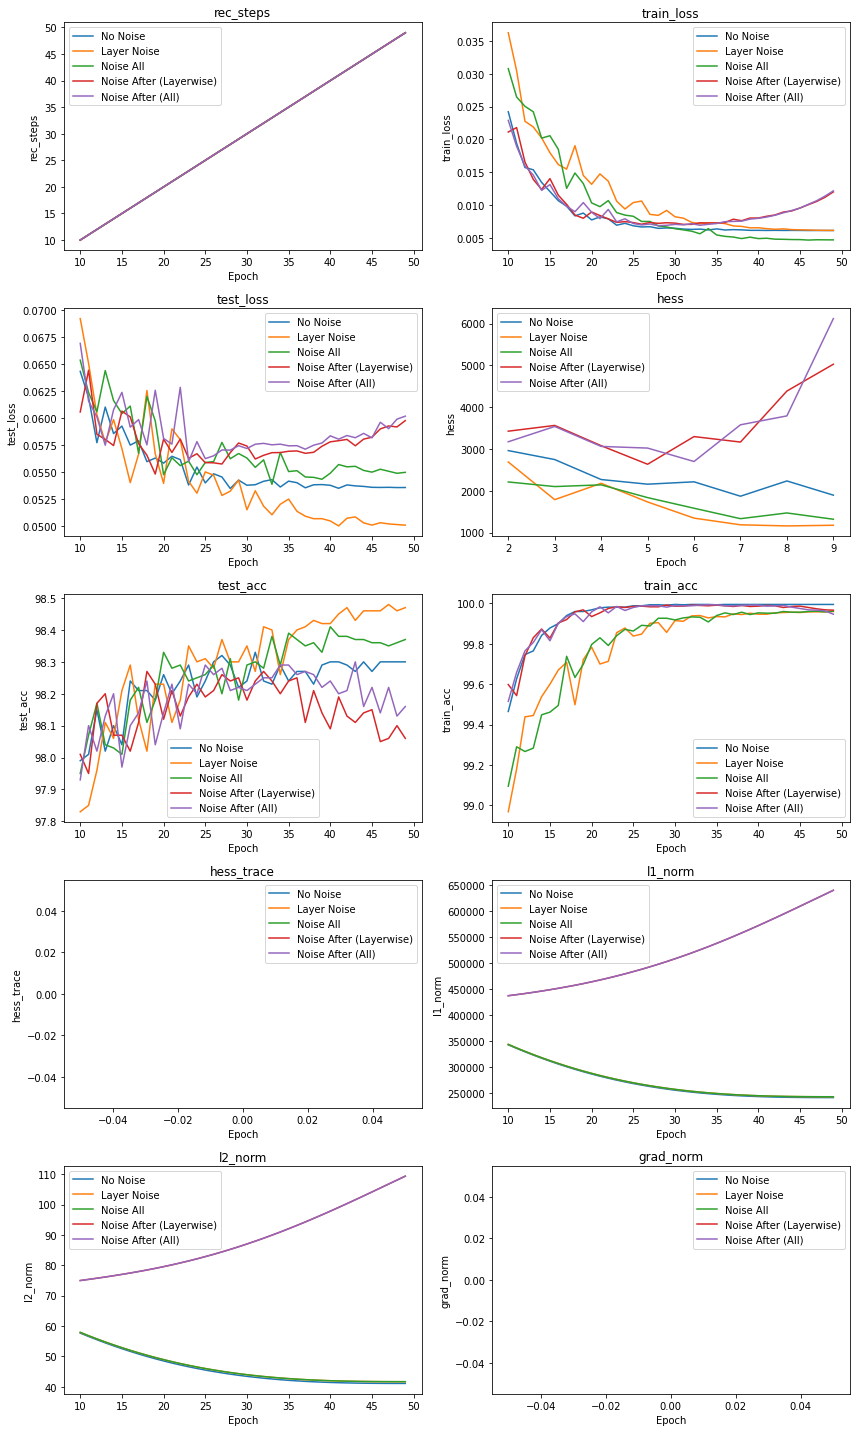

In [ ]:
# Assuming results_no and results_layer are dictionaries containing the respective metrics
results = {"No Noise": results_no, "Layer Noise": results_layer, "Noise All": results_all, "Noise After (Layerwise)": results_after_layer, "Noise After (All)": results_after_all}
plot_comparison(results)

## MNIST and MLP3

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Print the device being used
print("Device in use:", device)

dataset = "MNIST"
subset = 5000
no_of_ep = 50
batch_size = 128
rec_step = 1
net = "MLP3"
hess_record = True
save = True

print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -")
print("No Noise")
noise = "no" # no noise
sigma = 0.03
lr1 = 0.01
settings = {"dataset":dataset, "subset": subset, "net": net, "optimizer":"SGD", "scheduler":True, "noise":noise, "bs":batch_size, "lr":lr1, "sigma":sigma, "epochs":no_of_ep, "rec_step":rec_step, "hess_record": hess_record}
results_no = train_net(device, settings)
if(save):
    torch.save(results_no, 'results/'+settings_to_str(settings)+'.pt') 

print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -")
print("Layerwise Noise")
noise = "layer" #layer
sigma = 0.03
lr1 = 0.01
settings = {"dataset":dataset, "subset": subset, "net": net, "optimizer":"SGD", "scheduler":True, "noise":noise, "bs":batch_size, "lr":lr1, "sigma":sigma, "epochs":no_of_ep, "rec_step":rec_step, "hess_record": hess_record}
results_layer = train_net(device,settings)
if(save):
    torch.save(results_layer, 'results/'+settings_to_str(settings)+'.pt') 

print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -")
print("All Layer Noise")
noise = "all" # all
sigma = 0.03
lr1 = 0.01
settings = {"dataset":dataset, "subset": subset, "net": net, "optimizer":"SGD", "scheduler":True, "noise":noise, "bs":batch_size, "lr":lr1, "sigma":sigma, "epochs":no_of_ep, "rec_step":rec_step, "hess_record": hess_record}
results_all = train_net(device,settings)
if(save):
    torch.save(results_all, 'results/'+settings_to_str(settings)+'.pt') 

print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -")
print("After GD Noise All")
noise = "after_all" # after [noise injected after doing gradient descent]
sigma = 0.0003
lr1 = 0.01
settings = {"dataset":dataset, "subset": subset, "net": net, "optimizer":"SGD", "scheduler":True, "noise":noise, "bs":batch_size, "lr":lr1, "sigma":sigma, "epochs":no_of_ep, "rec_step":rec_step, "hess_record": hess_record}
results_after_all = train_net(device, settings)
if(save):
    torch.save(results_after_all, 'results/'+settings_to_str(settings)+'.pt') 

print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -")
print("After GD Noise Layer")
noise = "after_layer" # after [noise injected after doing gradient descent]
sigma = 0.0003
lr1 = 0.01
settings = {"dataset":dataset, "subset": subset, "net": net, "optimizer":"SGD", "scheduler":True, "noise":noise, "bs":batch_size, "lr":lr1, "sigma":sigma, "epochs":no_of_ep, "rec_step":rec_step, "hess_record": hess_record}
results_after_layer = train_net(device, settings)
if(save):
    torch.save(results_after_layer, 'results/'+settings_to_str(settings)+'.pt') 

Device in use: cuda
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
No Noise
Model dimension: 4799010
Number of groups: 12
Epoch 0: Train L: 2.3022, TrainAcc: 13.23, Test L: 2.3023, TestAcc: 13.41, LearningRate: 0.01000  Time Taken:  54.8405659198761
Epoch 1: Train L: 0.5214, TrainAcc: 84.62, Test L: 0.5203, TestAcc: 84.62, LearningRate: 0.00999  Time Taken:  25.758519172668457
Epoch 2: Train L: 0.1764, TrainAcc: 94.88, Test L: 0.1829, TestAcc: 94.44, LearningRate: 0.00996  Time Taken:  5.14969277381897
Epoch 3: Train L: 0.1270, TrainAcc: 96.18, Test L: 0.1463, TestAcc: 95.39, LearningRate: 0.00991  Time Taken:  5.2050464153289795
Epoch 4: Train L: 0.0736, TrainAcc: 97.94, Test L: 0.1012, TestAcc: 96.90, LearningRate: 0.00984  Time Taken:  5.1340813636779785
Epoch 5: Train L: 0.0539, TrainAcc: 98.45, Test L: 0.0907, TestAcc: 97.26, LearningRate: 0.00976  Time Taken:  5.133753299713135
Epoch 6: Train L: 0.0414, TrainAcc: 98.8

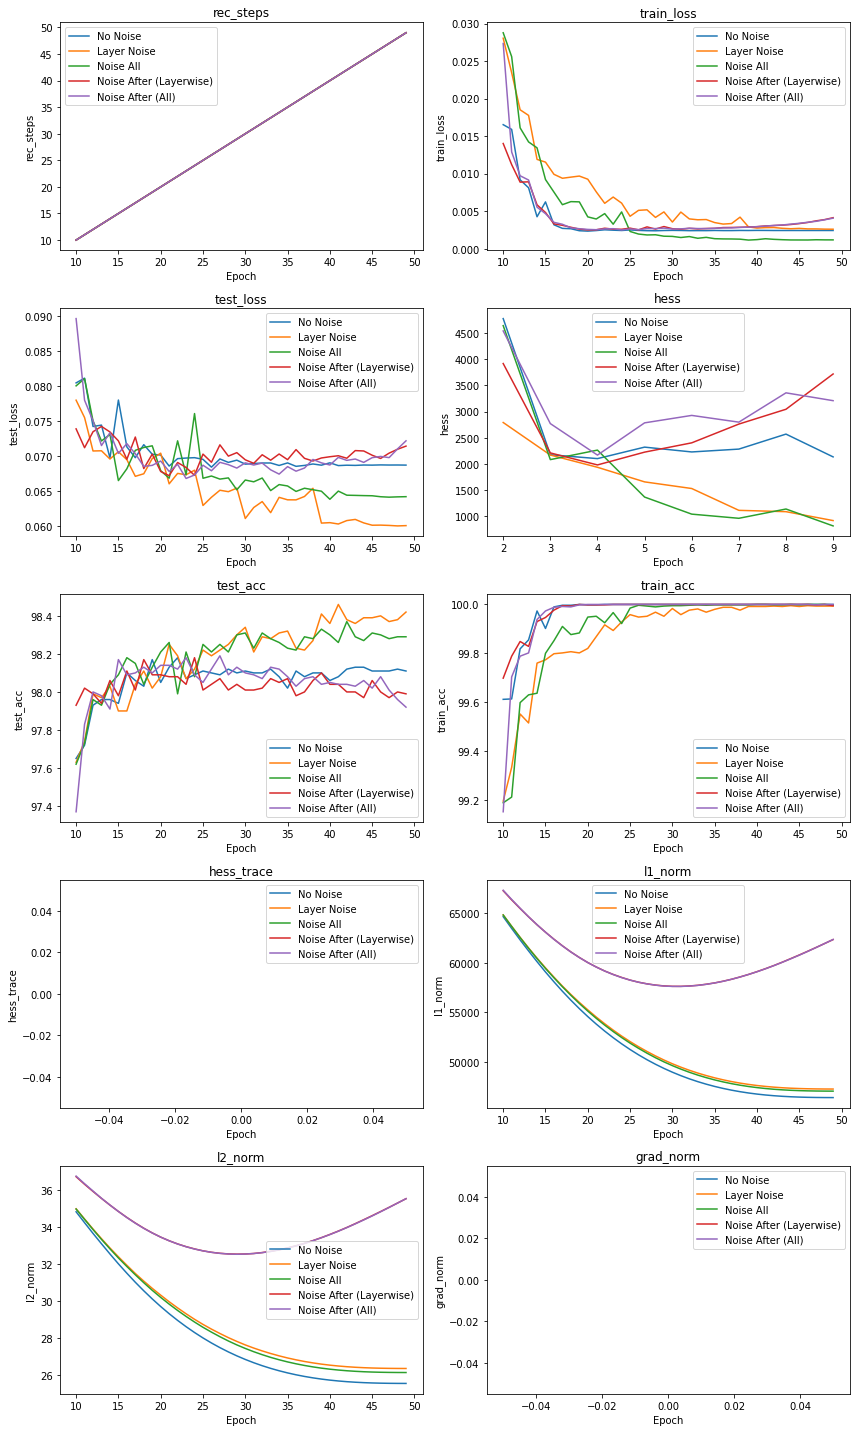

In [ ]:
# Assuming results_no and results_layer are dictionaries containing the respective metrics
results = {"No Noise": results_no, "Layer Noise": results_layer, "Noise All": results_all, "Noise After (Layerwise)": results_after_layer, "Noise After (All)": results_after_all}
plot_comparison(results)

# FMNIST

## FMNIST and MLP1

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Print the device being used
print("Device in use:", device)

dataset = "FMNIST"
subset = 5000
no_of_ep = 50
batch_size = 128
rec_step = 1
net = "MLP1"
hess_record = True
save = True

print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -")
print("No Noise")
noise = "no" # no noise
sigma = 0.03
lr1 = 0.01
settings = {"dataset":dataset, "subset": subset, "net": net, "optimizer":"SGD", "scheduler":True, "noise":noise, "bs":batch_size, "lr":lr1, "sigma":sigma, "epochs":no_of_ep, "rec_step":rec_step, "hess_record": hess_record}
results_no = train_net(device, settings)
if(save):
    torch.save(results_no, 'results/'+settings_to_str(settings)+'.pt') 

print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -")
print("Layerwise Noise")
noise = "layer" #layer
sigma = 0.03
lr1 = 0.01
settings = {"dataset":dataset, "subset": subset, "net": net, "optimizer":"SGD", "scheduler":True, "noise":noise, "bs":batch_size, "lr":lr1, "sigma":sigma, "epochs":no_of_ep, "rec_step":rec_step, "hess_record": hess_record}
results_layer = train_net(device,settings)
if(save):
    torch.save(results_layer, 'results/'+settings_to_str(settings)+'.pt') 

print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -")
print("All Layer Noise")
noise = "all" # all
sigma = 0.03
lr1 = 0.01
settings = {"dataset":dataset, "subset": subset, "net": net, "optimizer":"SGD", "scheduler":True, "noise":noise, "bs":batch_size, "lr":lr1, "sigma":sigma, "epochs":no_of_ep, "rec_step":rec_step, "hess_record": hess_record}
results_all = train_net(device,settings)
if(save):
    torch.save(results_all, 'results/'+settings_to_str(settings)+'.pt') 

print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -")
print("After GD Noise All")
noise = "after_all" # after [noise injected after doing gradient descent]
sigma = 0.0003
lr1 = 0.01
settings = {"dataset":dataset, "subset": subset, "net": net, "optimizer":"SGD", "scheduler":True, "noise":noise, "bs":batch_size, "lr":lr1, "sigma":sigma, "epochs":no_of_ep, "rec_step":rec_step, "hess_record": hess_record}
results_after_all = train_net(device, settings)
if(save):
    torch.save(results_after_all, 'results/'+settings_to_str(settings)+'.pt') 

print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -")
print("After GD Noise Layer")
noise = "after_layer" # after [noise injected after doing gradient descent]
sigma = 0.0003
lr1 = 0.01
settings = {"dataset":dataset, "subset": subset, "net": net, "optimizer":"SGD", "scheduler":True, "noise":noise, "bs":batch_size, "lr":lr1, "sigma":sigma, "epochs":no_of_ep, "rec_step":rec_step, "hess_record": hess_record}
results_after_layer = train_net(device, settings)
if(save):
    torch.save(results_after_layer, 'results/'+settings_to_str(settings)+'.pt') 

Device in use: cuda
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
No Noise
Model dimension: 898510
Number of groups: 8
Epoch 0: Train L: 2.3043, TrainAcc: 9.00, Test L: 2.3043, TestAcc: 8.91, LearningRate: 0.01000  Time Taken:  24.68200159072876
Epoch 1: Train L: 0.5218, TrainAcc: 81.76, Test L: 0.5494, TestAcc: 80.34, LearningRate: 0.00999  Time Taken:  21.626640558242798
Epoch 2: Train L: 0.4270, TrainAcc: 84.87, Test L: 0.4571, TestAcc: 83.44, LearningRate: 0.00996  Time Taken:  4.5352795124053955
Epoch 3: Train L: 0.3848, TrainAcc: 86.18, Test L: 0.4205, TestAcc: 84.86, LearningRate: 0.00991  Time Taken:  3.9869940280914307
Epoch 4: Train L: 0.3564, TrainAcc: 87.19, Test L: 0.3974, TestAcc: 85.81, LearningRate: 0.00984  Time Taken:  3.901144027709961
Epoch 5: Train L: 0.3413, TrainAcc: 87.40, Test L: 0.3881, TestAcc: 85.90, LearningRate: 0.00976  Time Taken:  4.008652687072754
Epoch 6: Train L: 0.3221, TrainAcc: 88.36,

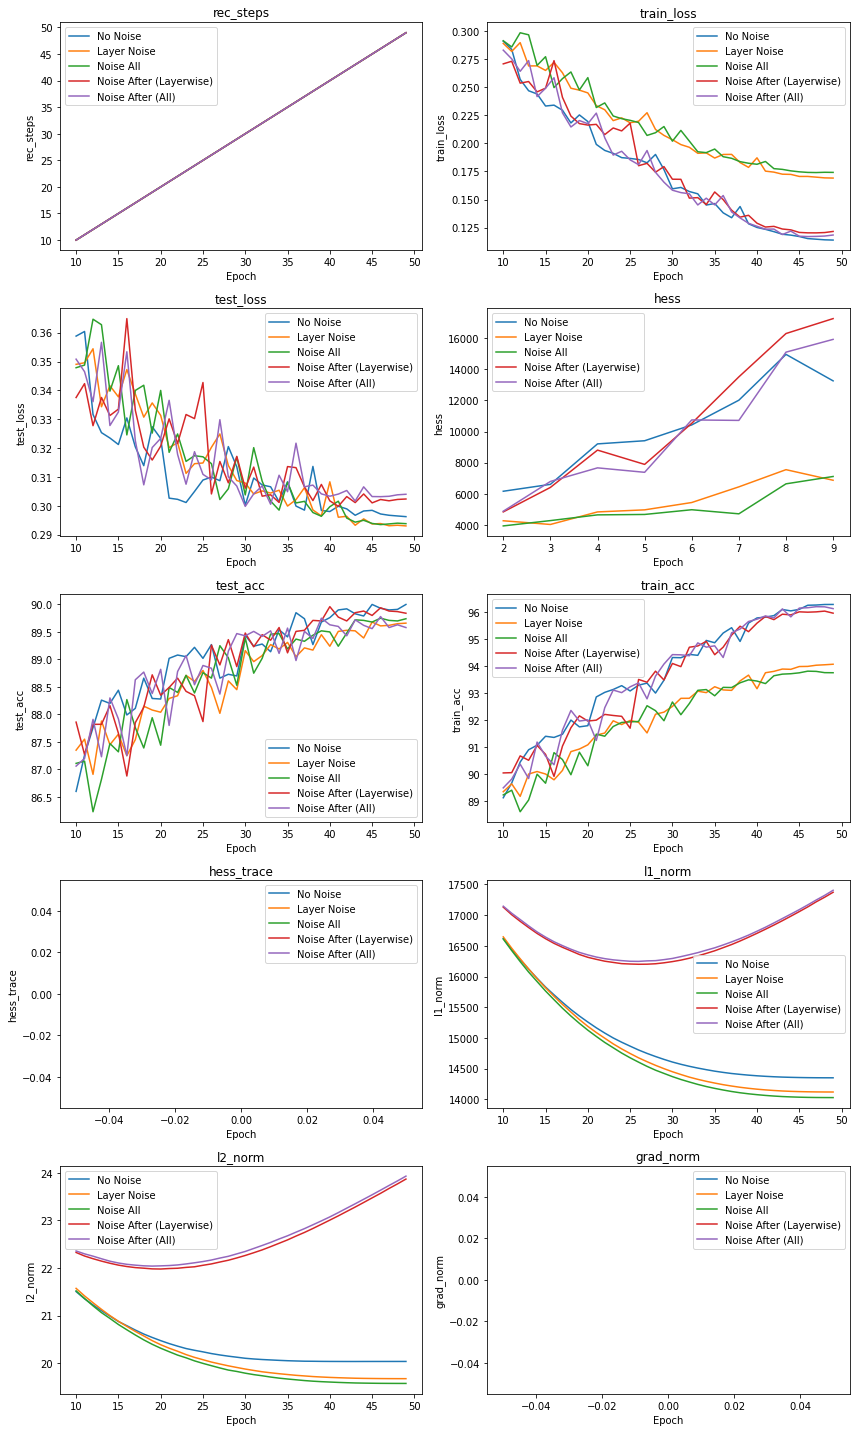

In [ ]:
# Assuming results_no and results_layer are dictionaries containing the respective metrics
results = {"No Noise": results_no, "Layer Noise": results_layer, "Noise All": results_all, "Noise After (Layerwise)": results_after_layer, "Noise After (All)": results_after_all}
plot_comparison(results)

## FMNIST and MLP2

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Print the device being used
print("Device in use:", device)

dataset = "FMNIST"
subset = 5000
no_of_ep = 50
batch_size = 128
rec_step = 1
net = "MLP2"
hess_record = True
save = True

print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -")
print("No Noise")
noise = "no" # no noise
sigma = 0.03
lr1 = 0.01
settings = {"dataset":dataset, "subset": subset, "net": net, "optimizer":"SGD", "scheduler":True, "noise":noise, "bs":batch_size, "lr":lr1, "sigma":sigma, "epochs":no_of_ep, "rec_step":rec_step, "hess_record": hess_record}
results_no = train_net(device, settings)
if(save):
    torch.save(results_no, 'results/'+settings_to_str(settings)+'.pt') 

print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -")
print("Layerwise Noise")
noise = "layer" #layer
sigma = 0.03
lr1 = 0.01
settings = {"dataset":dataset, "subset": subset, "net": net, "optimizer":"SGD", "scheduler":True, "noise":noise, "bs":batch_size, "lr":lr1, "sigma":sigma, "epochs":no_of_ep, "rec_step":rec_step, "hess_record": hess_record}
results_layer = train_net(device,settings)
if(save):
    torch.save(results_layer, 'results/'+settings_to_str(settings)+'.pt') 

print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -")
print("All Layer Noise")
noise = "all" # all
sigma = 0.03
lr1 = 0.01
settings = {"dataset":dataset, "subset": subset, "net": net, "optimizer":"SGD", "scheduler":True, "noise":noise, "bs":batch_size, "lr":lr1, "sigma":sigma, "epochs":no_of_ep, "rec_step":rec_step, "hess_record": hess_record}
results_all = train_net(device,settings)
if(save):
    torch.save(results_all, 'results/'+settings_to_str(settings)+'.pt') 

print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -")
print("After GD Noise All")
noise = "after_all" # after [noise injected after doing gradient descent]
sigma = 0.0003
lr1 = 0.01
settings = {"dataset":dataset, "subset": subset, "net": net, "optimizer":"SGD", "scheduler":True, "noise":noise, "bs":batch_size, "lr":lr1, "sigma":sigma, "epochs":no_of_ep, "rec_step":rec_step, "hess_record": hess_record}
results_after_all = train_net(device, settings)
if(save):
    torch.save(results_after_all, 'results/'+settings_to_str(settings)+'.pt') 

print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -")
print("After GD Noise Layer")
noise = "after_layer" # after [noise injected after doing gradient descent]
sigma = 0.0003
lr1 = 0.01
settings = {"dataset":dataset, "subset": subset, "net": net, "optimizer":"SGD", "scheduler":True, "noise":noise, "bs":batch_size, "lr":lr1, "sigma":sigma, "epochs":no_of_ep, "rec_step":rec_step, "hess_record": hess_record}
results_after_layer = train_net(device, settings)
if(save):
    torch.save(results_after_layer, 'results/'+settings_to_str(settings)+'.pt') 

Device in use: cuda
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
No Noise
Model dimension: 53985010
Number of groups: 8
Epoch 0: Train L: 2.3001, TrainAcc: 9.98, Test L: 2.3002, TestAcc: 10.14, LearningRate: 0.01000  Time Taken:  23.42473840713501
Epoch 1: Train L: 0.5303, TrainAcc: 80.83, Test L: 0.5547, TestAcc: 79.66, LearningRate: 0.00999  Time Taken:  57.02627086639404
Epoch 2: Train L: 0.4039, TrainAcc: 85.86, Test L: 0.4407, TestAcc: 84.64, LearningRate: 0.00996  Time Taken:  18.87584924697876
Epoch 3: Train L: 0.3438, TrainAcc: 87.68, Test L: 0.3839, TestAcc: 86.15, LearningRate: 0.00991  Time Taken:  20.812554359436035
Epoch 4: Train L: 0.3326, TrainAcc: 88.05, Test L: 0.3810, TestAcc: 86.19, LearningRate: 0.00984  Time Taken:  22.996569871902466
Epoch 5: Train L: 0.2988, TrainAcc: 89.18, Test L: 0.3564, TestAcc: 86.96, LearningRate: 0.00976  Time Taken:  24.02694869041443
Epoch 6: Train L: 0.2781, TrainAcc: 89.9

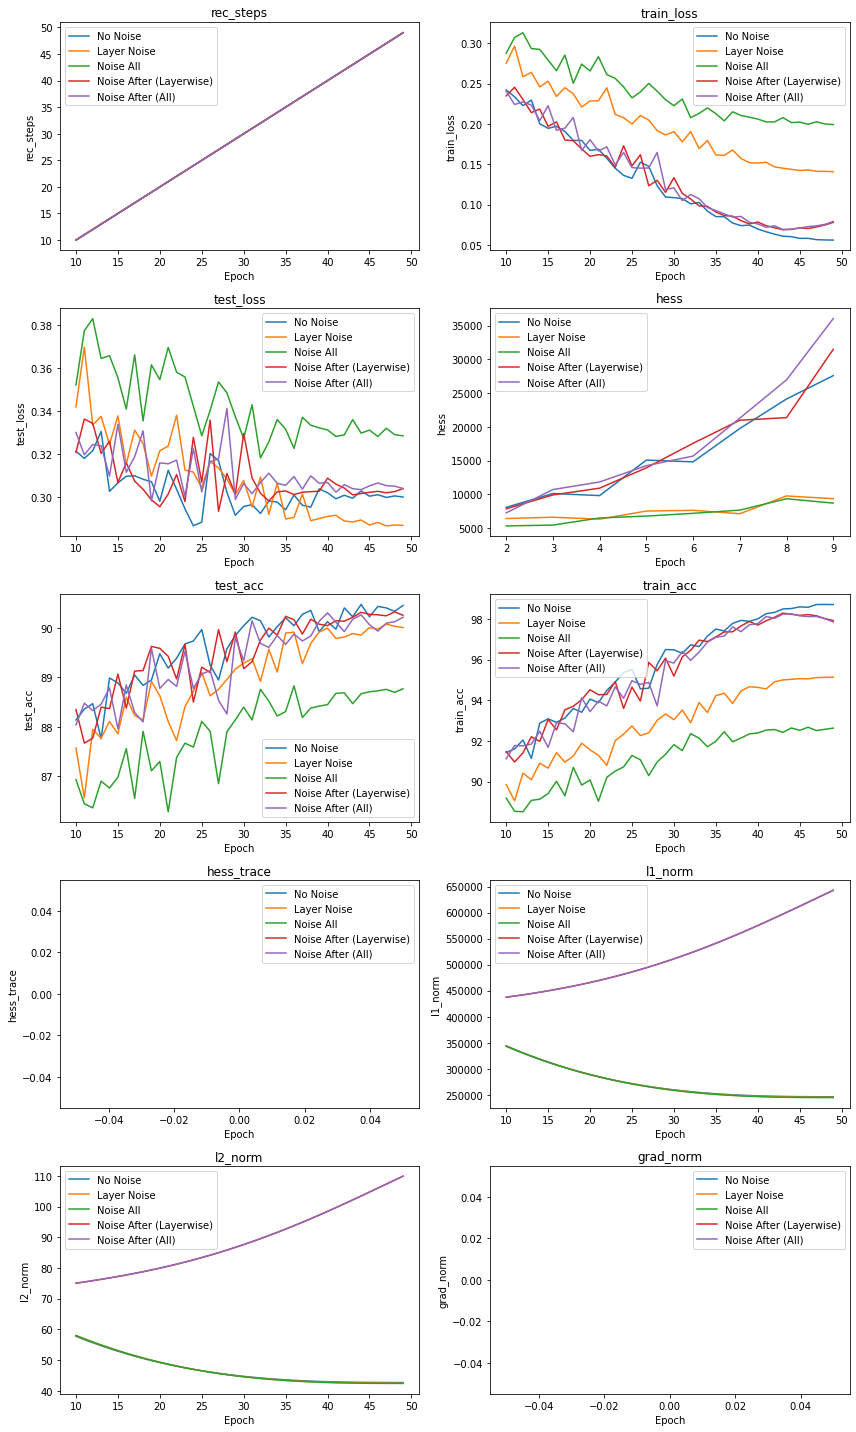

In [ ]:
# Assuming results_no and results_layer are dictionaries containing the respective metrics
results = {"No Noise": results_no, "Layer Noise": results_layer, "Noise All": results_all, "Noise After (Layerwise)": results_after_layer, "Noise After (All)": results_after_all}
plot_comparison(results)

## FMNIST and MLP3

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Print the device being used
print("Device in use:", device)

dataset = "FMNIST"
subset = 5000
no_of_ep = 50
batch_size = 128
rec_step = 1
net = "MLP3"
hess_record = True
save = True

print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -")
print("No Noise")
noise = "no" # no noise
sigma = 0.03
lr1 = 0.01
settings = {"dataset":dataset, "subset": subset, "net": net, "optimizer":"SGD", "scheduler":True, "noise":noise, "bs":batch_size, "lr":lr1, "sigma":sigma, "epochs":no_of_ep, "rec_step":rec_step, "hess_record": hess_record}
results_no = train_net(device, settings)
if(save):
    torch.save(results_no, 'results/'+settings_to_str(settings)+'.pt') 

print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -")
print("Layerwise Noise")
noise = "layer" #layer
sigma = 0.03
lr1 = 0.01
settings = {"dataset":dataset, "subset": subset, "net": net, "optimizer":"SGD", "scheduler":True, "noise":noise, "bs":batch_size, "lr":lr1, "sigma":sigma, "epochs":no_of_ep, "rec_step":rec_step, "hess_record": hess_record}
results_layer = train_net(device,settings)
if(save):
    torch.save(results_layer, 'results/'+settings_to_str(settings)+'.pt') 

print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -")
print("All Layer Noise")
noise = "all" # all
sigma = 0.03
lr1 = 0.01
settings = {"dataset":dataset, "subset": subset, "net": net, "optimizer":"SGD", "scheduler":True, "noise":noise, "bs":batch_size, "lr":lr1, "sigma":sigma, "epochs":no_of_ep, "rec_step":rec_step, "hess_record": hess_record}
results_all = train_net(device,settings)
if(save):
    torch.save(results_all, 'results/'+settings_to_str(settings)+'.pt') 

print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -")
print("After GD Noise All")
noise = "after_all" # after [noise injected after doing gradient descent]
sigma = 0.0003
lr1 = 0.01
settings = {"dataset":dataset, "subset": subset, "net": net, "optimizer":"SGD", "scheduler":True, "noise":noise, "bs":batch_size, "lr":lr1, "sigma":sigma, "epochs":no_of_ep, "rec_step":rec_step, "hess_record": hess_record}
results_after_all = train_net(device, settings)
if(save):
    torch.save(results_after_all, 'results/'+settings_to_str(settings)+'.pt') 

print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -")
print("After GD Noise Layer")
noise = "after_layer" # after [noise injected after doing gradient descent]
sigma = 0.0003
lr1 = 0.01
settings = {"dataset":dataset, "subset": subset, "net": net, "optimizer":"SGD", "scheduler":True, "noise":noise, "bs":batch_size, "lr":lr1, "sigma":sigma, "epochs":no_of_ep, "rec_step":rec_step, "hess_record": hess_record}
results_after_layer = train_net(device, settings)
if(save):
    torch.save(results_after_layer, 'results/'+settings_to_str(settings)+'.pt') 

Device in use: cuda
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
No Noise
Model dimension: 4799010
Number of groups: 12
Epoch 0: Train L: 2.3028, TrainAcc: 12.14, Test L: 2.3029, TestAcc: 11.90, LearningRate: 0.01000  Time Taken:  54.80431246757507
Epoch 1: Train L: 0.6575, TrainAcc: 76.08, Test L: 0.6777, TestAcc: 75.32, LearningRate: 0.00999  Time Taken:  24.23882794380188
Epoch 2: Train L: 0.4627, TrainAcc: 83.85, Test L: 0.4937, TestAcc: 82.60, LearningRate: 0.00996  Time Taken:  4.761721849441528
Epoch 3: Train L: 0.4083, TrainAcc: 85.39, Test L: 0.4473, TestAcc: 83.94, LearningRate: 0.00991  Time Taken:  4.507624626159668
Epoch 4: Train L: 0.3489, TrainAcc: 87.47, Test L: 0.3958, TestAcc: 85.74, LearningRate: 0.00984  Time Taken:  4.636312246322632
Epoch 5: Train L: 0.3327, TrainAcc: 87.80, Test L: 0.3835, TestAcc: 85.97, LearningRate: 0.00976  Time Taken:  4.574349880218506
Epoch 6: Train L: 0.3124, TrainAcc: 88.46

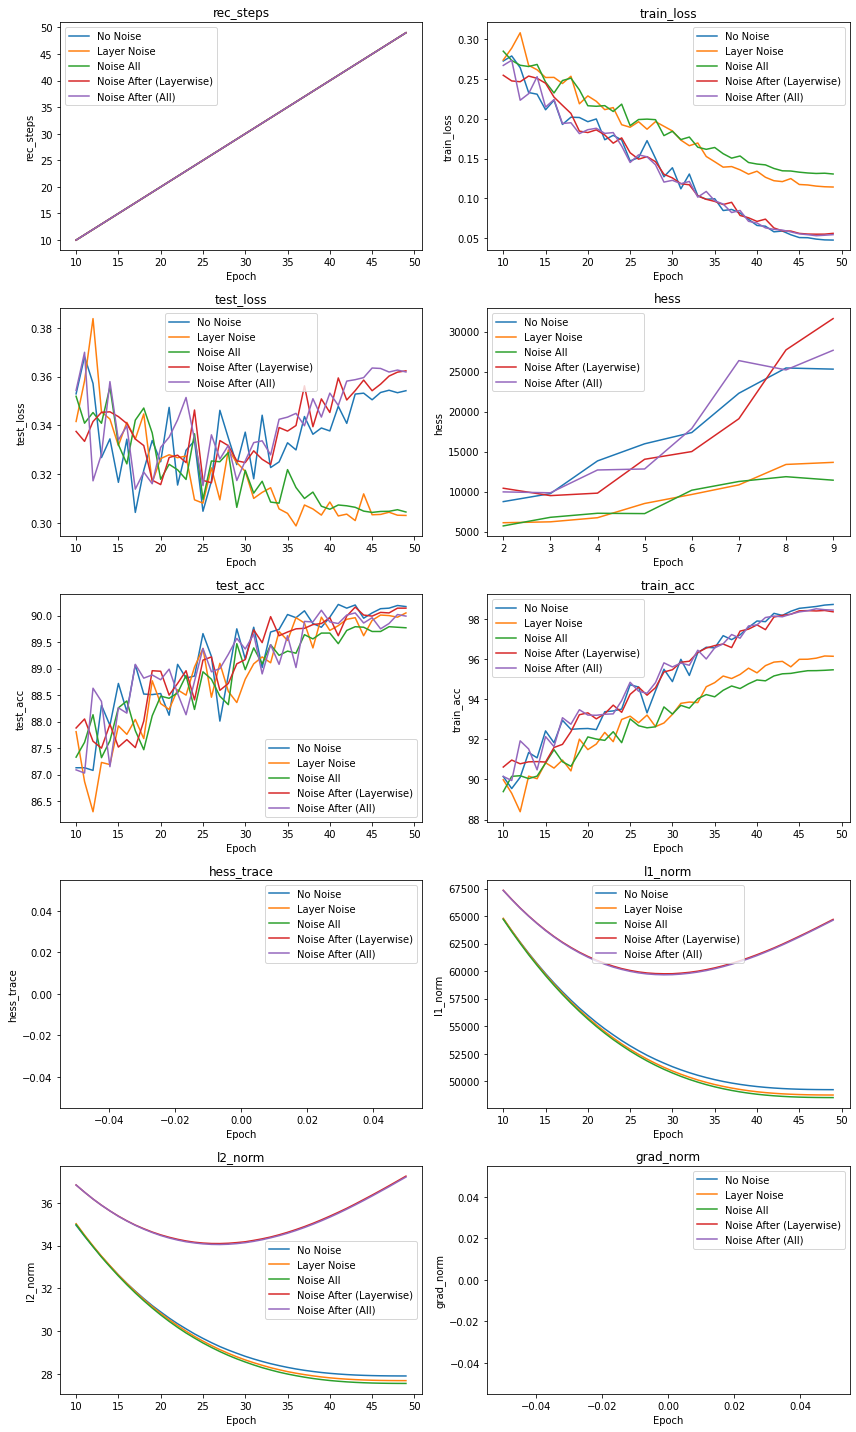

In [ ]:
# Assuming results_no and results_layer are dictionaries containing the respective metrics
results = {"No Noise": results_no, "Layer Noise": results_layer, "Noise All": results_all, "Noise After (Layerwise)": results_after_layer, "Noise After (All)": results_after_all}
plot_comparison(results)

# CIFAR10

## CIFAR and CNN1

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Print the device being used
print("Device in use:", device)
device = torch.device("cuda")
device

Device in use: cpu


device(type='cuda')

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda")
# Print the device being used
print("Device in use:", device)

dataset = "CIFAR"
subset = 5000
no_of_ep = 50
batch_size = 128
rec_step = 1
net = "CNN2"
hess_record = False
save = True

print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -")
print("No Noise")
noise = "no" # no noise
sigma = 0.05
lr1 = 0.01
settings = {"dataset":dataset, "subset": subset, "net": net, "optimizer":"SGD", "scheduler":True, "noise":noise, "bs":batch_size, "lr":lr1, "sigma":sigma, "epochs":no_of_ep, "rec_step":rec_step, "hess_record": hess_record}
results_no = train_net(device, settings)
if(save):
    torch.save(results_no, 'results/'+settings_to_str(settings)+'.pt') 

print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -")
print("Layerwise Noise")
noise = "layer" #layer
sigma = 0.05
lr1 = 0.01
settings = {"dataset":dataset, "subset": subset, "net": net, "optimizer":"SGD", "scheduler":True, "noise":noise, "bs":batch_size, "lr":lr1, "sigma":sigma, "epochs":no_of_ep, "rec_step":rec_step, "hess_record": hess_record}
results_layer = train_net(device,settings)
if(save):
    torch.save(results_layer, 'results/'+settings_to_str(settings)+'.pt') 

print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -")
print("All Layer Noise")
noise = "all" # all
sigma = 0.05
lr1 = 0.01
settings = {"dataset":dataset, "subset": subset, "net": net, "optimizer":"SGD", "scheduler":True, "noise":noise, "bs":batch_size, "lr":lr1, "sigma":sigma, "epochs":no_of_ep, "rec_step":rec_step, "hess_record": hess_record}
results_all = train_net(device,settings)
if(save):
    torch.save(results_all, 'results/'+settings_to_str(settings)+'.pt') 

print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -")
print("After GD Noise All")
noise = "after_all" # after [noise injected after doing gradient descent]
sigma = 0.005
lr1 = 0.01
settings = {"dataset":dataset, "subset": subset, "net": net, "optimizer":"SGD", "scheduler":True, "noise":noise, "bs":batch_size, "lr":lr1, "sigma":sigma, "epochs":no_of_ep, "rec_step":rec_step, "hess_record": hess_record}
results_after_all = train_net(device, settings)
if(save):
    torch.save(results_after_all, 'results/'+settings_to_str(settings)+'.pt') 

print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -")
print("After GD Noise Layer")
noise = "after_layer" # after [noise injected after doing gradient descent]
sigma = 0.005 
lr1 = 0.01
settings = {"dataset":dataset, "subset": subset, "net": net, "optimizer":"SGD", "scheduler":True, "noise":noise, "bs":batch_size, "lr":lr1, "sigma":sigma, "epochs":no_of_ep, "rec_step":rec_step, "hess_record": hess_record}
results_after_layer = train_net(device, settings)
if(save):
    torch.save(results_after_layer, 'results/'+settings_to_str(settings)+'.pt') 

Device in use: cuda
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
No Noise
Files already downloaded and verified
Files already downloaded and verified
Model dimension: 334346
Number of groups: 10
Epoch 0: Train L: 2.3022, TrainAcc: 12.48, Test L: 2.3016, TestAcc: 12.67, LearningRate: 0.01000  Time Taken:  88.47623705863953
Epoch 1: Train L: 1.6261, TrainAcc: 40.21, Test L: 1.5802, TestAcc: 42.45, LearningRate: 0.00999  Time Taken:  16.22783398628235
Epoch 2: Train L: 1.3689, TrainAcc: 50.11, Test L: 1.3179, TestAcc: 52.43, LearningRate: 0.00996  Time Taken:  16.427387475967407
Epoch 3: Train L: 1.1745, TrainAcc: 57.31, Test L: 1.1269, TestAcc: 58.53, LearningRate: 0.00991  Time Taken:  16.705000400543213
Epoch 4: Train L: 1.0655, TrainAcc: 62.71, Test L: 1.0136, TestAcc: 64.18, LearningRate: 0.00984  Time Taken:  17.072176456451416
Epoch 5: Train L: 0.9073, TrainAcc: 68.10, Test L: 0.9044, TestAcc: 67.58, LearningRate: 0.0

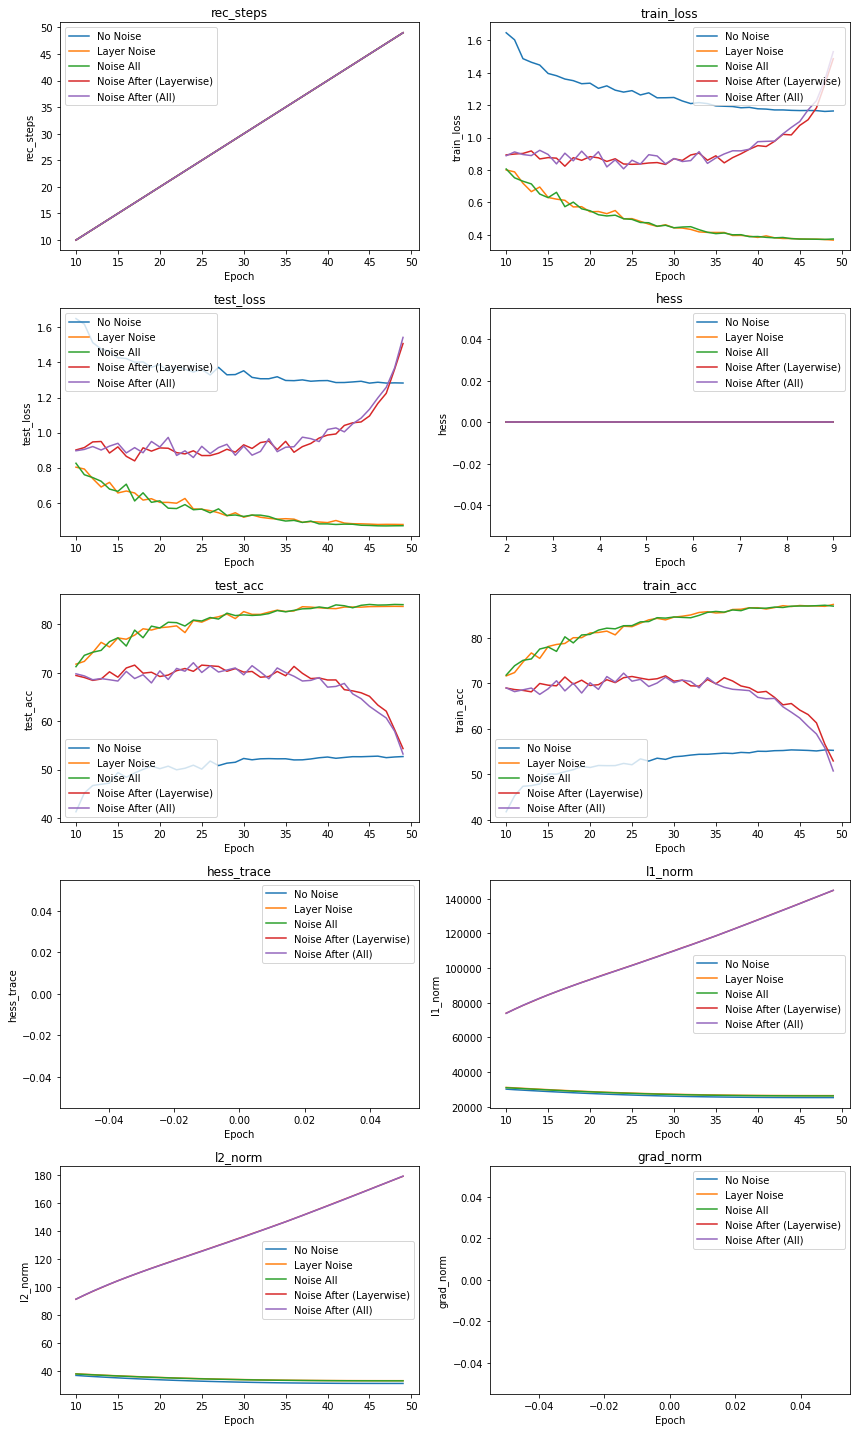

In [ ]:
# Assuming results_no and results_layer are dictionaries containing the respective metrics
results = {"No Noise": results_no, "Layer Noise": results_layer, "Noise All": results_all, "Noise After (Layerwise)": results_after_layer, "Noise After (All)": results_after_all}
plot_comparison(results)

In [ ]:
assert 1==2
torch.save(results_no, 'results/'+settings_to_str(settings)+'.pt') 
torch.save(results_layer, 'results/'+settings_to_str(settings)+'.pt')
torch.save(results_all, 'results/'+settings_to_str(settings)+'.pt') 
torch.save(results_after_all, 'results/'+settings_to_str(settings)+'.pt') 
torch.save(results_after_layer, 'results/'+settings_to_str(settings)+'.pt') 

In [ ]:
torch.cuda.is_available()

True

# Sentiment Analysis

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Print the device being used
print("Device in use:", device)

dataset = "imdb"
subset = 5000
no_of_ep = 50
batch_size = 128
rec_step = 1
net = "trans2"
hess_record = False
save = True

print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -")
print("No Noise")
noise = "no" # no noise
sigma = 0.05
lr1 = 0.01
settings = {"dataset":dataset, "subset": subset, "net": net, "optimizer":"SGD", "scheduler":True, "noise":noise, "bs":batch_size, "lr":lr1, "sigma":sigma, "epochs":no_of_ep, "rec_step":rec_step, "hess_record": hess_record}
results_no = train_net(device, settings)
if(save):
    torch.save(results_no, 'results/'+settings_to_str(settings)+'.pt') 

print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -")
print("Layerwise Noise")
noise = "layer" #layer
sigma = 0.05
lr1 = 0.01
settings = {"dataset":dataset, "subset": subset, "net": net, "optimizer":"SGD", "scheduler":True, "noise":noise, "bs":batch_size, "lr":lr1, "sigma":sigma, "epochs":no_of_ep, "rec_step":rec_step, "hess_record": hess_record}
results_layer = train_net(device,settings)
if(save):
    torch.save(results_layer, 'results/'+settings_to_str(settings)+'.pt') 

print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -")
print("All Layer Noise")
noise = "all" # all
sigma = 0.05
lr1 = 0.01
settings = {"dataset":dataset, "subset": subset, "net": net, "optimizer":"SGD", "scheduler":True, "noise":noise, "bs":batch_size, "lr":lr1, "sigma":sigma, "epochs":no_of_ep, "rec_step":rec_step, "hess_record": hess_record}
results_all = train_net(device,settings)
if(save):
    torch.save(results_all, 'results/'+settings_to_str(settings)+'.pt') 

print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -")
print("After GD Noise All")
noise = "after_all" # after [noise injected after doing gradient descent]
sigma = 0.005
lr1 = 0.01
settings = {"dataset":dataset, "subset": subset, "net": net, "optimizer":"SGD", "scheduler":True, "noise":noise, "bs":batch_size, "lr":lr1, "sigma":sigma, "epochs":no_of_ep, "rec_step":rec_step, "hess_record": hess_record}
results_after_all = train_net(device, settings)
if(save):
    torch.save(results_after_all, 'results/'+settings_to_str(settings)+'.pt') 

print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -")
print("After GD Noise Layer")
noise = "after_layer" # after [noise injected after doing gradient descent]
sigma = 0.005 
lr1 = 0.01
settings = {"dataset":dataset, "subset": subset, "net": net, "optimizer":"SGD", "scheduler":True, "noise":noise, "bs":batch_size, "lr":lr1, "sigma":sigma, "epochs":no_of_ep, "rec_step":rec_step, "hess_record": hess_record}
results_after_layer = train_net(device, settings)
if(save):
    torch.save(results_after_layer, 'results/'+settings_to_str(settings)+'.pt')  

Device in use: cuda
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
No Noise


d:\Programs\Python\lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


model not defined
Model dimension: 6041
Number of groups: 14


d:\Programs\Python\lib\site-packages\torch\nn\functional.py:5504: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


Epoch 0: Train L: 0.7376, TrainAcc: 50.29, Test L: 0.7453, TestAcc: 50.00, LearningRate: 0.01000  Time Taken:  11.191096782684326
Epoch 1: Train L: 0.6853, TrainAcc: 56.22, Test L: 0.6859, TestAcc: 55.90, LearningRate: 0.00999  Time Taken:  7.132426023483276
Epoch 2: Train L: 0.6834, TrainAcc: 54.56, Test L: 0.6833, TestAcc: 54.24, LearningRate: 0.00996  Time Taken:  7.11806321144104
Epoch 3: Train L: 0.6752, TrainAcc: 59.04, Test L: 0.6760, TestAcc: 59.52, LearningRate: 0.00991  Time Taken:  7.485442399978638
Epoch 4: Train L: 0.6720, TrainAcc: 57.67, Test L: 0.6724, TestAcc: 58.06, LearningRate: 0.00984  Time Taken:  7.394982576370239
Epoch 5: Train L: 0.6664, TrainAcc: 60.31, Test L: 0.6706, TestAcc: 60.12, LearningRate: 0.00976  Time Taken:  7.598365545272827
Epoch 6: Train L: 0.6875, TrainAcc: 53.74, Test L: 0.6867, TestAcc: 54.42, LearningRate: 0.00965  Time Taken:  7.582380771636963
Epoch 7: Train L: 0.6597, TrainAcc: 60.42, Test L: 0.6644, TestAcc: 60.70, LearningRate: 0.00952 

d:\Programs\Python\lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


model not defined
Model dimension: 6041
Number of groups: 14
Epoch 0: Train L: 0.8253, TrainAcc: 49.92, Test L: 0.8166, TestAcc: 50.30, LearningRate: 0.01000  Time Taken:  16.898631811141968
Epoch 1: Train L: 0.6869, TrainAcc: 54.56, Test L: 0.6883, TestAcc: 54.44, LearningRate: 0.00999  Time Taken:  16.02551007270813
Epoch 2: Train L: 0.6811, TrainAcc: 58.18, Test L: 0.6817, TestAcc: 57.76, LearningRate: 0.00996  Time Taken:  15.735417366027832
Epoch 3: Train L: 0.6778, TrainAcc: 58.07, Test L: 0.6799, TestAcc: 58.00, LearningRate: 0.00991  Time Taken:  16.045807600021362
Epoch 4: Train L: 0.6794, TrainAcc: 54.51, Test L: 0.6781, TestAcc: 54.94, LearningRate: 0.00984  Time Taken:  15.756256580352783
Epoch 5: Train L: 0.6675, TrainAcc: 60.68, Test L: 0.6671, TestAcc: 60.20, LearningRate: 0.00976  Time Taken:  16.347869396209717
Epoch 6: Train L: 0.6662, TrainAcc: 60.40, Test L: 0.6689, TestAcc: 59.54, LearningRate: 0.00965  Time Taken:  15.596631288528442
Epoch 7: Train L: 0.6634, Trai

d:\Programs\Python\lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


model not defined
Model dimension: 6041
Number of groups: 14
Epoch 0: Train L: 0.7850, TrainAcc: 49.92, Test L: 0.7766, TestAcc: 50.30, LearningRate: 0.01000  Time Taken:  17.13229513168335
Epoch 1: Train L: 0.6886, TrainAcc: 53.63, Test L: 0.6887, TestAcc: 53.98, LearningRate: 0.00999  Time Taken:  16.12796902656555
Epoch 2: Train L: 0.6821, TrainAcc: 57.23, Test L: 0.6829, TestAcc: 56.96, LearningRate: 0.00996  Time Taken:  15.659274101257324
Epoch 3: Train L: 0.6926, TrainAcc: 51.90, Test L: 0.6898, TestAcc: 52.64, LearningRate: 0.00991  Time Taken:  16.029714584350586
Epoch 4: Train L: 0.6718, TrainAcc: 59.72, Test L: 0.6730, TestAcc: 60.00, LearningRate: 0.00984  Time Taken:  16.295640468597412
Epoch 5: Train L: 0.6662, TrainAcc: 60.65, Test L: 0.6669, TestAcc: 59.92, LearningRate: 0.00976  Time Taken:  16.551761865615845
Epoch 6: Train L: 0.6624, TrainAcc: 60.78, Test L: 0.6648, TestAcc: 60.94, LearningRate: 0.00965  Time Taken:  16.204726934432983
Epoch 7: Train L: 0.6701, Train

d:\Programs\Python\lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


model not defined
Model dimension: 6041
Number of groups: 14
Epoch 0: Train L: 0.7449, TrainAcc: 50.06, Test L: 0.7488, TestAcc: 49.58, LearningRate: 0.01000  Time Taken:  17.293840646743774
Epoch 1: Train L: 0.6903, TrainAcc: 53.02, Test L: 0.6882, TestAcc: 52.34, LearningRate: 0.00999  Time Taken:  16.041622161865234
Epoch 2: Train L: 0.6859, TrainAcc: 55.26, Test L: 0.6866, TestAcc: 53.78, LearningRate: 0.00996  Time Taken:  16.264079809188843
Epoch 3: Train L: 0.6809, TrainAcc: 55.25, Test L: 0.6798, TestAcc: 55.54, LearningRate: 0.00991  Time Taken:  15.825605869293213
Epoch 4: Train L: 0.6851, TrainAcc: 55.64, Test L: 0.6904, TestAcc: 54.58, LearningRate: 0.00984  Time Taken:  16.352102756500244
Epoch 5: Train L: 0.6760, TrainAcc: 58.16, Test L: 0.6825, TestAcc: 57.50, LearningRate: 0.00976  Time Taken:  15.878725528717041
Epoch 6: Train L: 0.6677, TrainAcc: 60.29, Test L: 0.6731, TestAcc: 59.60, LearningRate: 0.00965  Time Taken:  16.51324772834778
Epoch 7: Train L: 0.6643, Trai

d:\Programs\Python\lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


model not defined
Model dimension: 6041
Number of groups: 14
Epoch 0: Train L: 0.7098, TrainAcc: 49.78, Test L: 0.7087, TestAcc: 49.82, LearningRate: 0.01000  Time Taken:  6.9062018394470215
Epoch 1: Train L: 0.6888, TrainAcc: 53.23, Test L: 0.6907, TestAcc: 52.64, LearningRate: 0.00999  Time Taken:  6.33613657951355
Epoch 2: Train L: 0.6836, TrainAcc: 54.63, Test L: 0.6808, TestAcc: 54.82, LearningRate: 0.00996  Time Taken:  6.30437445640564
Epoch 3: Train L: 0.6742, TrainAcc: 59.26, Test L: 0.6740, TestAcc: 58.60, LearningRate: 0.00991  Time Taken:  6.486264228820801
Epoch 4: Train L: 0.6712, TrainAcc: 59.25, Test L: 0.6700, TestAcc: 59.24, LearningRate: 0.00984  Time Taken:  7.265357255935669
Epoch 5: Train L: 0.6828, TrainAcc: 54.83, Test L: 0.6779, TestAcc: 54.98, LearningRate: 0.00976  Time Taken:  6.50035834312439
Epoch 6: Train L: 0.6615, TrainAcc: 61.58, Test L: 0.6596, TestAcc: 61.12, LearningRate: 0.00965  Time Taken:  6.606132507324219
Epoch 7: Train L: 0.7206, TrainAcc: 52

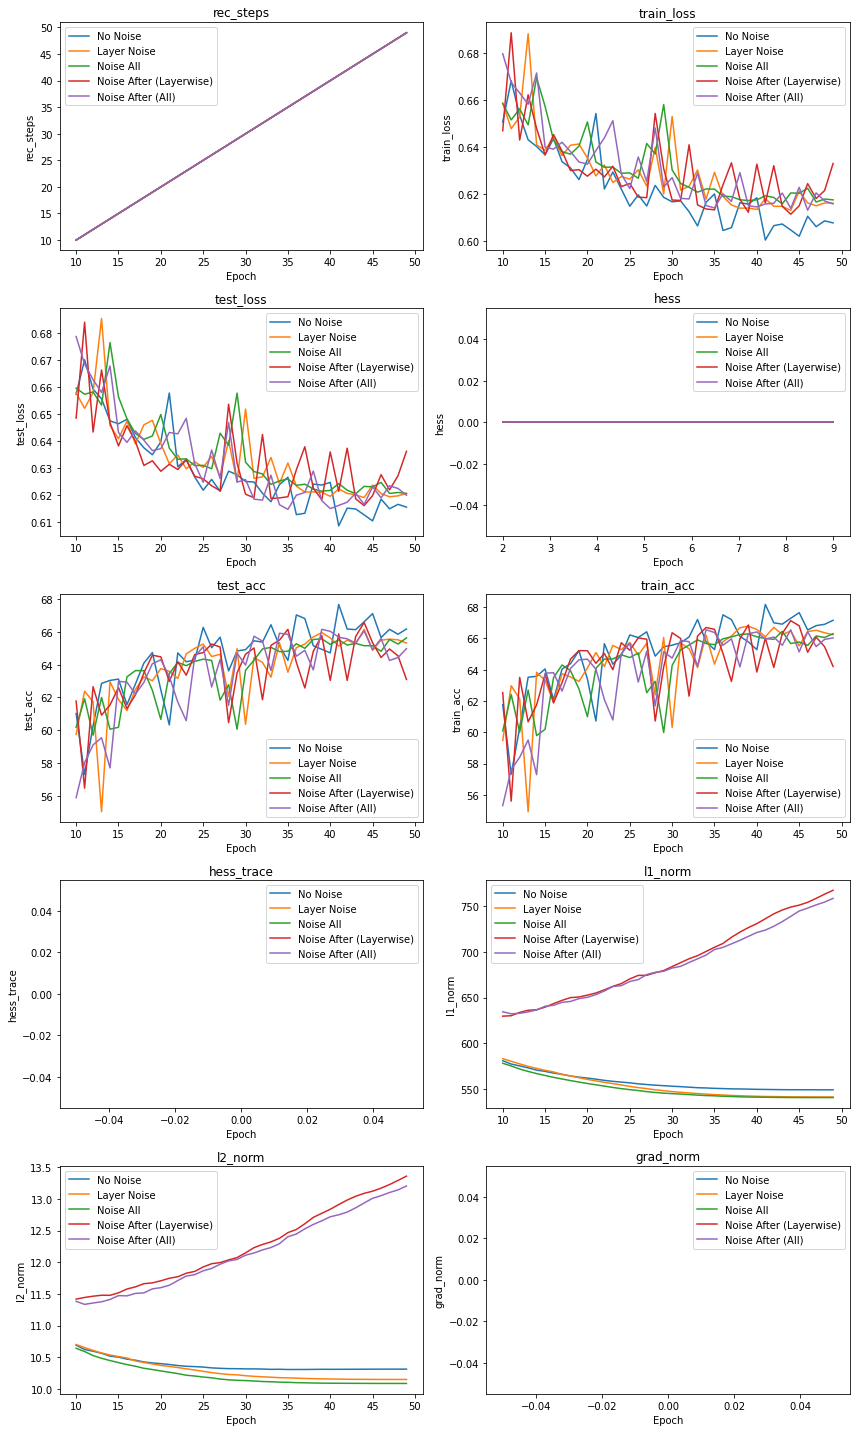

In [ ]:
# Assuming results_no and results_layer are dictionaries containing the respective metrics
results = {"No Noise": results_no, "Layer Noise": results_layer, "Noise All": results_all, "Noise After (Layerwise)": results_after_layer, "Noise After (All)": results_after_all}
plot_comparison(results)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Print the device being used
print("Device in use:", device)

dataset = "imdb"
subset = 5000
no_of_ep = 50
batch_size = 128
rec_step = 1
net = "trans3"
hess_record = False
save = True

print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -")
print("No Noise")
noise = "no" # no noise
sigma = 0.05
lr1 = 0.01
settings = {"dataset":dataset, "subset": subset, "net": net, "optimizer":"SGD", "scheduler":True, "noise":noise, "bs":batch_size, "lr":lr1, "sigma":sigma, "epochs":no_of_ep, "rec_step":rec_step, "hess_record": hess_record}
results_no = train_net(device, settings)
if(save):
    torch.save(results_no, 'results/'+settings_to_str(settings)+'.pt') 

print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -")
print("Layerwise Noise")
noise = "layer" #layer
sigma = 0.05
lr1 = 0.01
settings = {"dataset":dataset, "subset": subset, "net": net, "optimizer":"SGD", "scheduler":True, "noise":noise, "bs":batch_size, "lr":lr1, "sigma":sigma, "epochs":no_of_ep, "rec_step":rec_step, "hess_record": hess_record}
results_layer = train_net(device,settings)
if(save):
    torch.save(results_layer, 'results/'+settings_to_str(settings)+'.pt') 

print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -")
print("All Layer Noise")
noise = "all" # all
sigma = 0.05
lr1 = 0.01
settings = {"dataset":dataset, "subset": subset, "net": net, "optimizer":"SGD", "scheduler":True, "noise":noise, "bs":batch_size, "lr":lr1, "sigma":sigma, "epochs":no_of_ep, "rec_step":rec_step, "hess_record": hess_record}
results_all = train_net(device,settings)
if(save):
    torch.save(results_all, 'results/'+settings_to_str(settings)+'.pt') 

print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -")
print("After GD Noise All")
noise = "after_all" # after [noise injected after doing gradient descent]
sigma = 0.005
lr1 = 0.01
settings = {"dataset":dataset, "subset": subset, "net": net, "optimizer":"SGD", "scheduler":True, "noise":noise, "bs":batch_size, "lr":lr1, "sigma":sigma, "epochs":no_of_ep, "rec_step":rec_step, "hess_record": hess_record}
results_after_all = train_net(device, settings)
if(save):
    torch.save(results_after_all, 'results/'+settings_to_str(settings)+'.pt') 

print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -")
print("After GD Noise Layer")
noise = "after_layer" # after [noise injected after doing gradient descent]
sigma = 0.005 
lr1 = 0.01
settings = {"dataset":dataset, "subset": subset, "net": net, "optimizer":"SGD", "scheduler":True, "noise":noise, "bs":batch_size, "lr":lr1, "sigma":sigma, "epochs":no_of_ep, "rec_step":rec_step, "hess_record": hess_record}
results_after_layer = train_net(device, settings)
if(save):
    torch.save(results_after_layer, 'results/'+settings_to_str(settings)+'.pt')  

Device in use: cuda
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
No Noise


d:\Programs\Python\lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Model dimension: 55570
Number of groups: 74
Epoch 0: Train L: 0.7431, TrainAcc: 50.08, Test L: 0.7464, TestAcc: 49.70, LearningRate: 0.01000  Time Taken:  13.844625234603882
Epoch 1: Train L: 0.6933, TrainAcc: 50.12, Test L: 0.6938, TestAcc: 49.68, LearningRate: 0.00999  Time Taken:  12.656374454498291
Epoch 2: Train L: 0.6928, TrainAcc: 50.67, Test L: 0.6933, TestAcc: 50.08, LearningRate: 0.00996  Time Taken:  22.72880458831787
Epoch 3: Train L: 0.6927, TrainAcc: 50.33, Test L: 0.6920, TestAcc: 50.66, LearningRate: 0.00991  Time Taken:  17.12336301803589
Epoch 4: Train L: 0.6935, TrainAcc: 50.48, Test L: 0.6928, TestAcc: 50.62, LearningRate: 0.00984  Time Taken:  19.27594017982483
Epoch 5: Train L: 0.6915, TrainAcc: 52.08, Test L: 0.6914, TestAcc: 51.86, LearningRate: 0.00976  Time Taken:  22.534514665603638
Epoch 6: Train L: 0.6897, TrainAcc: 53.55, Test L: 0.6891, TestAcc: 54.40, LearningRate: 0.00965  Time Taken:  29.296573162078857
Epoch 7: Train L: 0.7035, TrainAcc: 50.16, Test L

d:\Programs\Python\lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Model dimension: 55570
Number of groups: 74
Epoch 0: Train L: 0.7081, TrainAcc: 50.24, Test L: 0.7089, TestAcc: 50.06, LearningRate: 0.01000  Time Taken:  14.0384840965271
Epoch 1: Train L: 0.6969, TrainAcc: 50.08, Test L: 0.6990, TestAcc: 49.70, LearningRate: 0.00999  Time Taken:  14.86724328994751
Epoch 2: Train L: 0.6923, TrainAcc: 51.24, Test L: 0.6928, TestAcc: 51.50, LearningRate: 0.00996  Time Taken:  15.337912559509277
Epoch 3: Train L: 0.6897, TrainAcc: 54.09, Test L: 0.6901, TestAcc: 52.30, LearningRate: 0.00991  Time Taken:  16.173266649246216
Epoch 4: Train L: 0.6894, TrainAcc: 52.93, Test L: 0.6893, TestAcc: 52.30, LearningRate: 0.00984  Time Taken:  16.826278924942017
Epoch 5: Train L: 0.6840, TrainAcc: 54.92, Test L: 0.6829, TestAcc: 56.06, LearningRate: 0.00976  Time Taken:  17.00921893119812
Epoch 6: Train L: 0.6735, TrainAcc: 59.01, Test L: 0.6758, TestAcc: 58.90, LearningRate: 0.00965  Time Taken:  17.287697076797485
Epoch 7: Train L: 0.6656, TrainAcc: 59.26, Test L:

d:\Programs\Python\lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Model dimension: 55570
Number of groups: 74
Epoch 0: Train L: 0.8402, TrainAcc: 49.92, Test L: 0.8308, TestAcc: 50.30, LearningRate: 0.01000  Time Taken:  13.644182205200195
Epoch 1: Train L: 0.6960, TrainAcc: 50.08, Test L: 0.6980, TestAcc: 49.70, LearningRate: 0.00999  Time Taken:  15.177042961120605
Epoch 2: Train L: 0.6920, TrainAcc: 51.43, Test L: 0.6929, TestAcc: 51.50, LearningRate: 0.00996  Time Taken:  15.6078519821167
Epoch 3: Train L: 0.6912, TrainAcc: 51.51, Test L: 0.6916, TestAcc: 51.24, LearningRate: 0.00991  Time Taken:  15.935929775238037
Epoch 4: Train L: 0.6956, TrainAcc: 50.27, Test L: 0.6977, TestAcc: 49.76, LearningRate: 0.00984  Time Taken:  16.433396816253662
Epoch 5: Train L: 0.6976, TrainAcc: 50.49, Test L: 0.6950, TestAcc: 50.70, LearningRate: 0.00976  Time Taken:  16.80999183654785
Epoch 6: Train L: 0.6832, TrainAcc: 56.06, Test L: 0.6857, TestAcc: 56.06, LearningRate: 0.00965  Time Taken:  16.90455174446106
Epoch 7: Train L: 0.6704, TrainAcc: 59.33, Test L:

d:\Programs\Python\lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Model dimension: 55570
Number of groups: 74
Epoch 0: Train L: 0.6936, TrainAcc: 50.53, Test L: 0.6935, TestAcc: 49.44, LearningRate: 0.01000  Time Taken:  14.815876483917236
Epoch 1: Train L: 0.6929, TrainAcc: 50.44, Test L: 0.6929, TestAcc: 50.92, LearningRate: 0.00999  Time Taken:  19.741379737854004
Epoch 2: Train L: 0.6925, TrainAcc: 51.71, Test L: 0.6931, TestAcc: 51.38, LearningRate: 0.00996  Time Taken:  17.03958249092102
Epoch 3: Train L: 0.7033, TrainAcc: 49.92, Test L: 0.7007, TestAcc: 50.30, LearningRate: 0.00991  Time Taken:  17.820985317230225
Epoch 4: Train L: 0.6923, TrainAcc: 51.47, Test L: 0.6921, TestAcc: 51.36, LearningRate: 0.00984  Time Taken:  18.964961290359497
Epoch 5: Train L: 0.6916, TrainAcc: 52.19, Test L: 0.6915, TestAcc: 52.48, LearningRate: 0.00976  Time Taken:  23.1721830368042
Epoch 6: Train L: 0.6888, TrainAcc: 53.87, Test L: 0.6895, TestAcc: 53.92, LearningRate: 0.00965  Time Taken:  19.06032967567444
Epoch 7: Train L: 0.6859, TrainAcc: 54.36, Test L:

d:\Programs\Python\lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Model dimension: 55570
Number of groups: 74
Epoch 0: Train L: 0.7389, TrainAcc: 50.09, Test L: 0.7467, TestAcc: 49.70, LearningRate: 0.01000  Time Taken:  15.229825973510742
Epoch 1: Train L: 0.6935, TrainAcc: 50.72, Test L: 0.6948, TestAcc: 50.02, LearningRate: 0.00999  Time Taken:  15.117460012435913
Epoch 2: Train L: 0.6919, TrainAcc: 51.67, Test L: 0.6916, TestAcc: 52.36, LearningRate: 0.00996  Time Taken:  17.193699836730957
Epoch 3: Train L: 0.6889, TrainAcc: 54.47, Test L: 0.6891, TestAcc: 54.66, LearningRate: 0.00991  Time Taken:  18.744813919067383
Epoch 4: Train L: 0.6750, TrainAcc: 58.61, Test L: 0.6751, TestAcc: 59.12, LearningRate: 0.00984  Time Taken:  18.623343467712402
Epoch 5: Train L: 0.6593, TrainAcc: 60.75, Test L: 0.6583, TestAcc: 60.12, LearningRate: 0.00976  Time Taken:  19.440129280090332
Epoch 6: Train L: 0.6603, TrainAcc: 61.04, Test L: 0.6622, TestAcc: 60.60, LearningRate: 0.00965  Time Taken:  20.094009399414062
Epoch 7: Train L: 0.6497, TrainAcc: 61.65, Tes

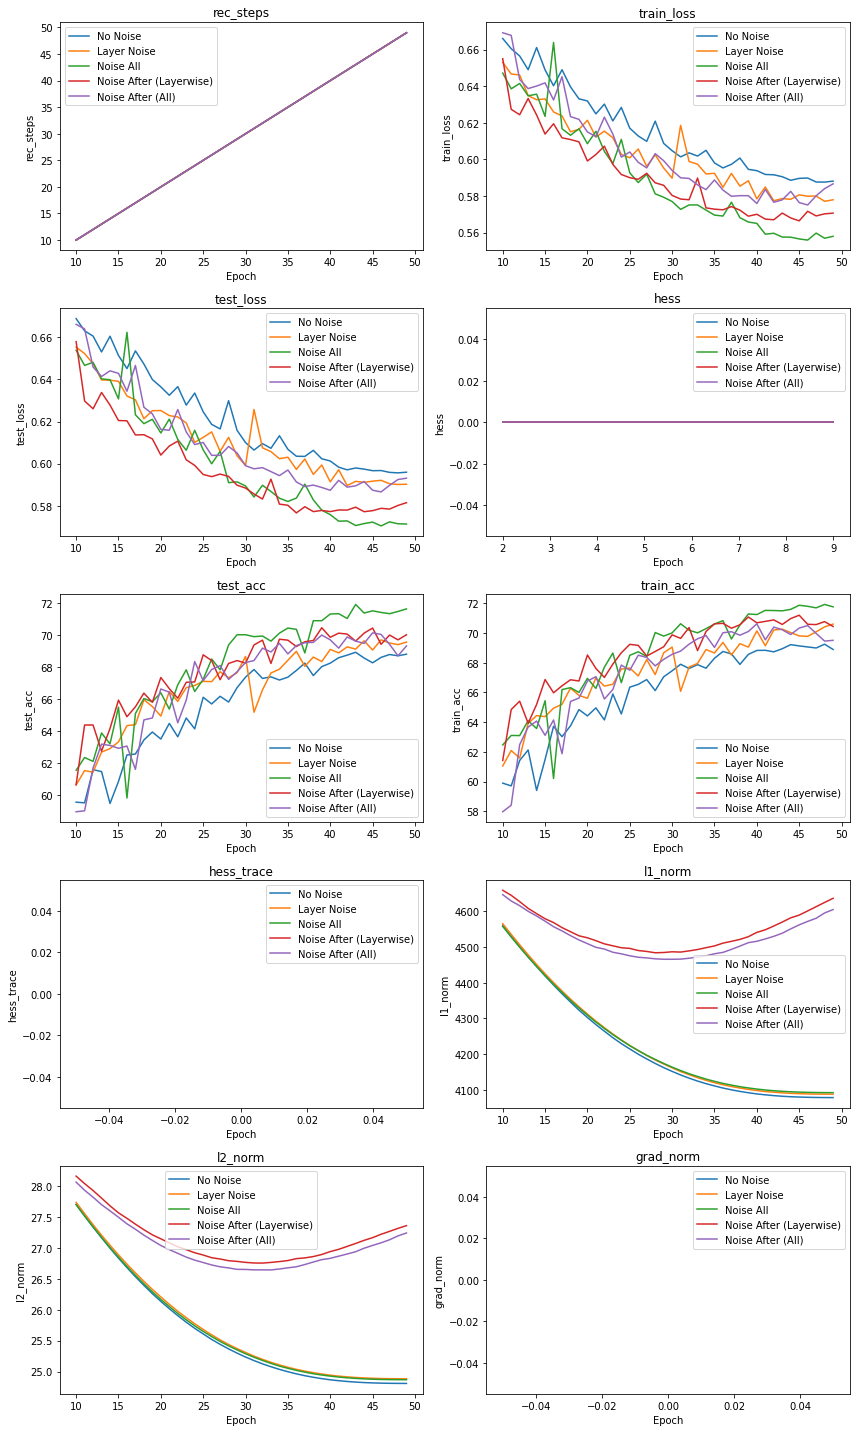

In [ ]:
# Assuming results_no and results_layer are dictionaries containing the respective metrics
results = {"No Noise": results_no, "Layer Noise": results_layer, "Noise All": results_all, "Noise After (Layerwise)": results_after_layer, "Noise After (All)": results_after_all}
plot_comparison(results)

# NER

In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Print the device being used
print("Device in use:", device)

dataset = "conll2003"
subset = 5000
no_of_ep = 50
batch_size = 128
rec_step = 1
net = "NER1"
hess_record = False
save = True

print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -")
print("No Noise")
noise = "no" # no noise
sigma = 0.05
lr1 = 0.01
settings = {"dataset":dataset, "subset": subset, "net": net, "optimizer":"SGD", "scheduler":True, "noise":noise, "bs":batch_size, "lr":lr1, "sigma":sigma, "epochs":no_of_ep, "rec_step":rec_step, "hess_record": hess_record}
results_no = train_net(device, settings)
if(save):
    torch.save(results_no, 'results/'+settings_to_str(settings)+'.pt') 

print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -")
print("Layerwise Noise")
noise = "layer" #layer
sigma = 0.05
lr1 = 0.01
settings = {"dataset":dataset, "subset": subset, "net": net, "optimizer":"SGD", "scheduler":True, "noise":noise, "bs":batch_size, "lr":lr1, "sigma":sigma, "epochs":no_of_ep, "rec_step":rec_step, "hess_record": hess_record}
results_layer = train_net(device,settings)
if(save):
    torch.save(results_layer, 'results/'+settings_to_str(settings)+'.pt') 

print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -")
print("All Layer Noise")
noise = "all" # all
sigma = 0.05
lr1 = 0.01
settings = {"dataset":dataset, "subset": subset, "net": net, "optimizer":"SGD", "scheduler":True, "noise":noise, "bs":batch_size, "lr":lr1, "sigma":sigma, "epochs":no_of_ep, "rec_step":rec_step, "hess_record": hess_record}
results_all = train_net(device,settings)
if(save):
    torch.save(results_all, 'results/'+settings_to_str(settings)+'.pt') 

print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -")
print("After GD Noise All")
noise = "after_all" # after [noise injected after doing gradient descent]
sigma = 0.005
lr1 = 0.01
settings = {"dataset":dataset, "subset": subset, "net": net, "optimizer":"SGD", "scheduler":True, "noise":noise, "bs":batch_size, "lr":lr1, "sigma":sigma, "epochs":no_of_ep, "rec_step":rec_step, "hess_record": hess_record}
results_after_all = train_net(device, settings)
if(save):
    torch.save(results_after_all, 'results/'+settings_to_str(settings)+'.pt') 

print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -")
print("After GD Noise Layer")
noise = "after_layer" # after [noise injected after doing gradient descent]
sigma = 0.005 
lr1 = 0.01
settings = {"dataset":dataset, "subset": subset, "net": net, "optimizer":"SGD", "scheduler":True, "noise":noise, "bs":batch_size, "lr":lr1, "sigma":sigma, "epochs":no_of_ep, "rec_step":rec_step, "hess_record": hess_record}
results_after_layer = train_net(device, settings)
if(save):
    torch.save(results_after_layer, 'results/'+settings_to_str(settings)+'.pt')  

Device in use: cuda
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
No Noise
Model dimension: 30051959
Number of groups: 35
Epoch 0: Train L: 2.1994, TrainAcc: 11.65, Test L: 2.1994, TestAcc: 11.65, LearningRate: 0.01000  Time Taken:  6.170647382736206
Epoch 1: Train L: 2.1802, TrainAcc: 17.06, Test L: 2.1802, TestAcc: 17.06, LearningRate: 0.00999  Time Taken:  3.118140697479248
Epoch 2: Train L: 1.0111, TrainAcc: 73.10, Test L: 1.0107, TestAcc: 73.10, LearningRate: 0.00996  Time Taken:  3.1310389041900635
Epoch 3: Train L: 0.2005, TrainAcc: 98.00, Test L: 0.2005, TestAcc: 98.00, LearningRate: 0.00991  Time Taken:  3.0792341232299805
Epoch 4: Train L: 0.1445, TrainAcc: 98.11, Test L: 0.1445, TestAcc: 98.11, LearningRate: 0.00984  Time Taken:  3.0231006145477295
Epoch 5: Train L: 0.1405, TrainAcc: 98.11, Test L: 0.1405, TestAcc: 98.11, LearningRate: 0.00976  Time Taken:  3.005547046661377
Epoch 6: Train L: 0.1378, TrainAcc: 9

In [45]:
def plot_comparison(results_dict):
    num_metrics = len(next(iter(results_dict.values())))
    num_plots = num_metrics // 2 + num_metrics % 2  # Calculate the number of rows required for plotting

    fig, axes = plt.subplots(num_plots, 2, figsize=(12, 4 * num_plots))

    for i, metric in enumerate(list(results_dict.values())[0]):
        row = i // 2
        col = i % 2

        for label, results in results_dict.items():
            axes[row, col].plot([i for i in range(len(results[metric])//5, len(results[metric]))], results[metric][len(results[metric])//5:], label=label)

        axes[row, col].set_title(metric)
        axes[row, col].set_xlabel("Epoch")
        axes[row, col].set_ylabel(metric)
        axes[row, col].legend()

    plt.tight_layout()
    plt.show()

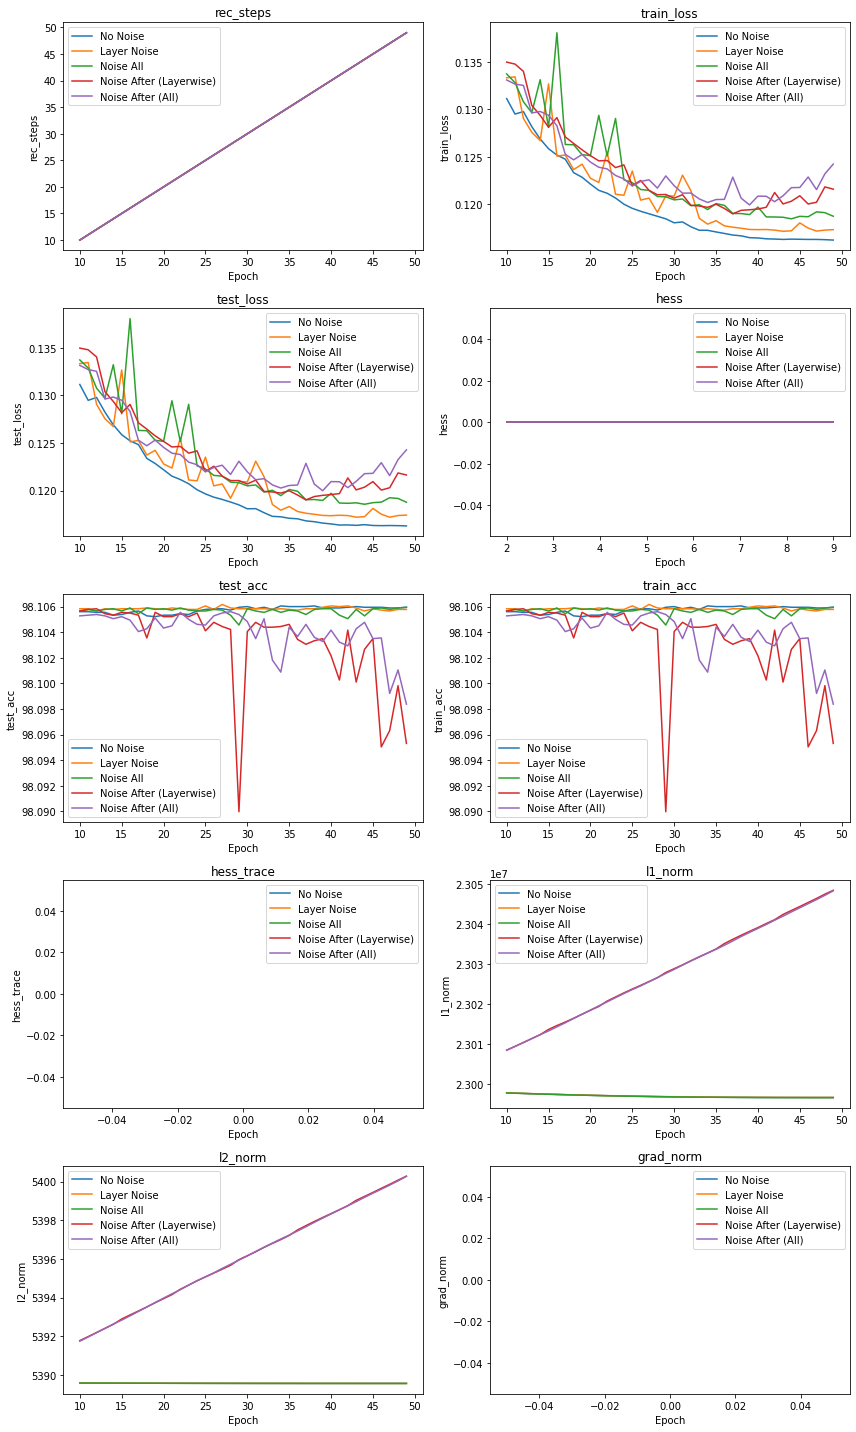

In [46]:
# Assuming results_no and results_layer are dictionaries containing the respective metrics
results = {"No Noise": results_no, "Layer Noise": results_layer, "Noise All": results_all, "Noise After (Layerwise)": results_after_layer, "Noise After (All)": results_after_all}
plot_comparison(results)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Print the device being used
print("Device in use:", device)

dataset = "min_temp"
subset = 5000
no_of_ep = 150
batch_size = 128
rec_step = 1
sigma_val =  0.000001
net = "LSTM"
hess_record = False
save = True

print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -")
print("No Noise")
noise = "no" # no noise
sigma = sigma_val
lr1 = 0.01
settings = {"dataset":dataset, "subset": subset, "net": net, "optimizer":"SGD", "scheduler":True, "noise":noise, "bs":batch_size, "lr":lr1, "sigma":sigma, "epochs":no_of_ep, "rec_step":rec_step, "hess_record": hess_record}
results_no = train_net(device, settings)
if(save):
    torch.save(results_no, 'results/'+settings_to_str(settings)+'.pt') 

print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -")
print("Layerwise Noise")
noise = "layer" #layer
sigma = sigma_val
lr1 = 0.01
settings = {"dataset":dataset, "subset": subset, "net": net, "optimizer":"SGD", "scheduler":True, "noise":noise, "bs":batch_size, "lr":lr1, "sigma":sigma, "epochs":no_of_ep, "rec_step":rec_step, "hess_record": hess_record}
results_layer = train_net(device,settings)
if(save):
    torch.save(results_layer, 'results/'+settings_to_str(settings)+'.pt') 

print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -")
print("All Layer Noise")
noise = "all" # all
sigma = sigma_val
lr1 = 0.01
settings = {"dataset":dataset, "subset": subset, "net": net, "optimizer":"SGD", "scheduler":True, "noise":noise, "bs":batch_size, "lr":lr1, "sigma":sigma, "epochs":no_of_ep, "rec_step":rec_step, "hess_record": hess_record}
results_all = train_net(device,settings)
if(save):
    torch.save(results_all, 'results/'+settings_to_str(settings)+'.pt') 

print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -")
print("After GD Noise All")
noise = "after_all" # after [noise injected after doing gradient descent]
sigma = sigma_val
lr1 = 0.01
settings = {"dataset":dataset, "subset": subset, "net": net, "optimizer":"SGD", "scheduler":True, "noise":noise, "bs":batch_size, "lr":lr1, "sigma":sigma, "epochs":no_of_ep, "rec_step":rec_step, "hess_record": hess_record}
results_after_all = train_net(device, settings)
if(save):
    torch.save(results_after_all, 'results/'+settings_to_str(settings)+'.pt') 

print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -")
print("After GD Noise Layer")
noise = "after_layer" # after [noise injected after doing gradient descent]
sigma = sigma_val
lr1 = 0.01
settings = {"dataset":dataset, "subset": subset, "net": net, "optimizer":"SGD", "scheduler":True, "noise":noise, "bs":batch_size, "lr":lr1, "sigma":sigma, "epochs":no_of_ep, "rec_step":rec_step, "hess_record": hess_record}
results_after_layer = train_net(device, settings)
if(save):
    torch.save(results_after_layer, 'results/'+settings_to_str(settings)+'.pt')